In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.interpolate import interp1d
from math import ceil
import glob
from scipy.integrate import solve_ivp
import seaborn as sns
from numpy.random import normal, poisson

# Stimulus

In [2]:
def stimulus(fname):
    '''
    Interpolates and creates function for stimulus input from file
    :param fname: stimulus input
    :return: voltage function
    '''
    
    v_m = np.loadtxt(fname)
    plt.plot(v_m)
    
    v_m = interp1d(v_m[:, 0] * 1000, v_m[:, 1], kind='cubic', fill_value="extrapolate")
    #plt.plot(v_m)

    return v_m

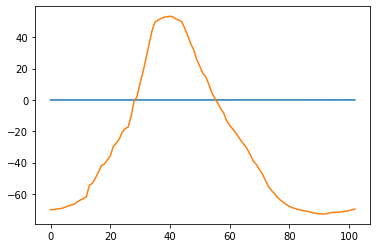

In [3]:
fname = './pre_ap_voltage.txt'
v_m = stimulus(fname)

# Transitions

In [4]:
# transition rate functions
# from Bischofberger and Jonas (2002) and Nadkarni et al (2010/2012)
# All in units of ms
# Temperature adjustment from paper
q10 = 2.0  # rxn rate increase with 10 degC temp change; assumuption of uniform
            # q10 for all reactions here
delta_temp = 10.0  # parameters are given at 24C so raise temp by 10C to 34C
                    # (rat internal temp)
temp_comp = q10 ** (delta_temp / 10.)  # change in rxn rate due to deltaT eqtn


# 1ST TRANSITION
v1 = 49.14  # mV


def a1(t):
    '''
    alpha 1 forward transition rate
    :param t: time
    :return: equation for alpha_1
    '''

    a1o = 4.04  # msec-1

    return temp_comp * a1o * np.exp(v_m(t) / v1)


def b1(t):
    '''
    beta 1 backward transition rate
    :param t: time int/double value or array
    :return: equation for beta_1
    '''

    b1o = 2.88  # msec-1

    return temp_comp * b1o * np.exp(-v_m(t) / v1)


# 2ND TRANSITION
v2 = 42.08  # mV


def a2(t):
    '''
    alpha 2 forward transition rate
    :param t: time
    :return: equation for alpha_2
    '''

    a2o = 6.70  # msec-1

    return temp_comp * a2o * np.exp(v_m(t) / v2)


def b2(t):
    '''
    beta 2 backward transition rate
    :param t: time
    :return: equation for beta_2
    '''

    b2o = 6.30  # msec-1

    return temp_comp * b2o * np.exp(-v_m(t) / v2)


# 3RD TRANSITION
v3 = 55.31  # mV


def a3(t):
    '''
    alpha 3 forward transition rate
    :param t: time
    :return: equation for alpha_3
    '''

    a3o = 4.39  # msec-1

    return temp_comp * a3o * np.exp(v_m(t) / v3)


def b3(t):
    '''
    beta 3 backward transition rate
    :param t: time
    :return: equation for beta_3
    '''

    b3o = 8.16  # msec-1

    return temp_comp * b3o * np.exp(-v_m(t) / v3)

# 4TH TRANSITION
v4 = 26.55  # mV


def a4(t):
    '''
    alpha 4 forward transition rate
    :param t: time
    :return: equation for alpha_4
    '''

    a4o = 17.33  # msec-1

    return temp_comp * a4o * np.exp(v_m(t) / v4)


def b4(t):
    '''
    beta 4 backward transition rate
    :param t: time
    :return: equation for beta_4
    '''

    b4o = 1.84  # msec-1

    return temp_comp*b4o * np.exp(-v_m(t) / v4)

# CALCIUM INFLUX
# Current influx rate constant (k_ca)
# 1/ms


def k_ca(t):
    f_ca = 511080.18/1802251    # correction factor for only calcium in current
    g_hva = f_ca * 1.55 * 2.4e-12  # conductance (3.72 pS; adjusted for temperature)
    c = 80.36   # mV
    d = 0.3933  # parameter determining current rectification and reversal potential
    e_c = 1.6e-19  # Coulombic charge of one electron (e = F/NA)
    Z_ca = 2  # Charge of calcium ion

    return g_hva * v_m(t) * (d - np.exp(-v_m(t) / c)) / ((1000 ** 2) * Z_ca * e_c * (1 - np.exp(v_m(t) / c)))


# ODE Solver

In [5]:
##########################
####### ODE SOLVER #######
##########################
def vdcc_odes(t, state):
    '''
    ODEs to describe vdcc states according to Markov diagram
    :param t: time
    :param state: states of vdcc
    :return: odes describing each state
    '''

    c0, c1, c2, c3, o, ca = state

    eqtns = []
    eqtns.append(b1(t)*c1 - a1(t)*c0)
    
    eqtns.append(a1(t)*c0 + b2(t)*c2 - (b1(t) + a2(t))*c1)
    
    eqtns.append(a2(t)*c1 + b3(t)*c3 - (b2(t) + a3(t))*c2)
    
    eqtns.append(a3(t)*c2 + b4(t)*o - (b3(t) + a4(t))*c3)
    
    eqtns.append(a4(t)*c3 - b4(t)*o)
    
    eqtns.append(k_ca(t)*o)

    return eqtns


In [6]:
dt = 1e-3
t_start = 0
t_stop = 10
trange = np.arange(t_start, t_stop+dt, dt)
ode_results = solve_ivp(vdcc_odes, [t_start, t_stop+dt], [1, 0, 0, 0, 0, 0],
                        t_eval=trange)

In [7]:
#dt = 1e-6
#t_start = 0
#t_stop = 10
#trange = np.arange(t_start, t_stop+dt, dt)
#ode_results_small_dt = solve_ivp(vdcc_odes, [t_start, t_stop+dt], [1, 0, 0, 0, 0, 0],
#                        t_eval=trange)

In [8]:
dt = 1e-4
t_start = 0
t_stop = 10
trange = np.arange(t_start, t_stop+dt, dt)
ode_results_smaller_dt = solve_ivp(vdcc_odes, [t_start, t_stop+dt], [1, 0, 0, 0, 0, 0],
                        t_eval=trange)

# Euler ODE

In [7]:
##########################
### EULER INTEGRATION ####
##########################

def euler(y0, t_start, t_stop, dt):
    t = np.arange(t_start, t_stop + dt, dt)
    
    # Initialize states
    c0, c1, c2, c3, o, ca = [np.zeros(len(trange)) for _ in range(len(y0))]
    
    # Initial conditions
    c0[0] = y0[0]
    c1[0] = y0[1]
    c2[0] = y0[2]
    c3[0] = y0[3]
    o[0] = y0[4] 
    ca[0] = y0[5]
    
    # Step forward in time
    for n in range(len(trange) - 1):
        #print(n)
        c0[n+1] = c0[n] + (b1(t[n])*c1[n] - a1(t[n])*c0[n])*dt
        c1[n+1] = c1[n] + (a1(t[n])*c0[n] + b2(t[n])*c2[n] - (b1(t[n]) + a2(t[n]))*c1[n])*dt
        c2[n+1] = c2[n] + (a2(t[n])*c1[n] + b3(t[n])*c3[n] - (b2(t[n]) + a3(t[n]))*c2[n])*dt
        c3[n+1] = c3[n] + (a3(t[n])*c2[n] + b4(t[n])*o[n] -  (b3(t[n]) + a4(t[n]))*c3[n])*dt
        o[n+1] = o[n] + (a4(t[n])*c3[n] - b4(t[n])*o[n])*dt
        ca[n+1] = ca[n] + (k_ca(t[n])*o[n])*dt
        
    return c0, c1, c2, c3, o, ca
    
 


In [8]:
# Initial conditions
y0 = [1, 0, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10
t = np.arange(t_start, t_stop + dt, dt)


c0, c1, c2, c3, o, ca = euler(y0, t_start, t_stop, dt)

In [9]:
#%timeit -n 1 -r 10 euler(y0, t_start, t_stop, dt)

In [10]:
#%timeit -n 1 -r 10 solve_ivp(vdcc_odes,[t_start, t_stop+dt], [1, 0, 0, 0, 0, 0], t_eval=trange)
#%timeit -n 1 -r 10 markov_vdcc_n(65, trange, dt)

# Poisson SDE

In [11]:
def poisson_sde(y0, t_start, t_stop, dt):
    t = np.arange(t_start, t_stop + dt, dt) # range of t values

    # Initialize states
    c0, c1, c2, c3, op = [np.zeros(len(t)) for _ in range(len(y0))] # mean values

    nc = y0[0] # number of channels

    # Initial conditions
    c0[0] = y0[0]
    c1[0] = y0[1]
    c2[0] = y0[2]
    c3[0] = y0[3]
    op[0] = y0[4]

    # Simulate
    for n in range(len(t) - 1):
        # for each state, sample each possible transition using Poisson sampling
        # C0
        p_trans_c0 = [0, a1(t[n])*dt, 0, 0, 0]
        
        trans_c0 = []
        for p in p_trans_c0:
            trans_c0.append(np.round(np.random.poisson(c0[n]*p)))
            
        trans_c0[0] = c0[n] - sum(trans_c0)
        
        
        # C1
        p_trans_c1 = [b1(t[n])*dt, 0, a2(t[n])*dt, 0, 0]
        
        trans_c1 = []
        for p in p_trans_c1:
            trans_c1.append(np.round(np.random.poisson(c1[n]*p)))
            
        trans_c1[1] = c1[n] - sum(trans_c1)
        
        
        # C2
        p_trans_c2 = [0, b2(t[n])*dt, 0, a3(t[n])*dt, 0]
        
        trans_c2 = []
        for p in p_trans_c2:
            trans_c2.append(np.round(np.random.poisson(c2[n]*p)))
            
        trans_c2[2] = c2[n] - sum(trans_c2)
        
        
        # C3
        p_trans_c3 = [0, 0, b3(t[n])*dt, 0, a4(t[n])*dt]
        
        trans_c3 = []
        for p in p_trans_c3:
            trans_c3.append(np.round(np.random.poisson(c3[n]*p)))
            
        trans_c3[3] = c3[n] - sum(trans_c3)
        
        
        # OP
        p_trans_op = [0, 0, 0, b4(t[n])*dt, 0]
        
        trans_op = []
        for p in p_trans_op:
            trans_op.append(np.round(np.random.poisson(op[n]*p)))
            
        trans_op[4] = op[n] - sum(trans_op)
        
        
        # Update for next time step
        c0[n+1] = trans_c0[0] + trans_c1[0] + trans_c2[0] + trans_c3[0] + trans_op[0]
        c1[n+1] = trans_c0[1] + trans_c1[1] + trans_c2[1] + trans_c3[1] + trans_op[1]
        c2[n+1] = trans_c0[2] + trans_c1[2] + trans_c2[2] + trans_c3[2] + trans_op[2]
        c3[n+1] = trans_c0[3] + trans_c1[3] + trans_c2[3] + trans_c3[3] + trans_op[3]
        op[n+1] = trans_c0[4] + trans_c1[4] + trans_c2[4] + trans_c3[4] + trans_op[4]
        
        c0[n+1] = np.clip(c0[n+1], 0, nc)
        c1[n+1] = np.clip(c1[n+1], 0, nc)
        c2[n+1] = np.clip(c2[n+1], 0, nc)
        c3[n+1] = np.clip(c3[n+1], 0, nc)
        op[n+1] = np.clip(op[n+1], 0, nc)
        
    return c0, c1, c2, c3, op

In [12]:
# Run simulation
# Initial conditions
y0 = [65, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10
t = np.arange(t_start, t_stop + dt, dt) # range of t values

print("Starting simulation...")
c0_p, c1_p, c2_p, c3_p, op_p = poisson_sde(y0, t_start, t_stop, dt)
print("Done.")

Starting simulation...
Done.


# Run a bunch of Poisson

In [13]:
# Run simulation
# Initial conditions
y0 = [65, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10
t = np.arange(t_start, t_stop + dt, dt) # range of t values

print("Starting simulation...")
c0_p, c1_p, c2_p, c3_p, op_p = poisson_sde(y0, t_start, t_stop, dt)
print("Done.")

Starting simulation...
Done.


In [93]:
N_RUNS = 100
N_VDCC_STATES = 5
# Run simulation
# Initial conditions
y0 = [65, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10
t = np.arange(t_start, t_stop + dt, dt) # range of t values

poisson_vdcc_states = np.empty([len(t), N_VDCC_STATES, N_RUNS])

In [94]:
# Run simulation
for i in range(N_RUNS):
    c0_p, c1_p, c2_p, c3_p, op_p = poisson_sde(y0, t_start, t_stop, dt)
    
    poisson_vdcc_states[:, 0, i] = c0_p
    poisson_vdcc_states[:, 1, i] = c1_p
    poisson_vdcc_states[:, 2, i] = c2_p
    poisson_vdcc_states[:, 3, i] = c3_p
    poisson_vdcc_states[:, 4, i] = op_p

In [95]:
# trial number for each time point
trial = np.empty(N_RUNS*len(trange))

for run in range(N_RUNS):
    for tp in range(len(trange)):
        trial[len(trange)*run + tp] = run + 1
        
# repeat timepoints for each trial
timepoints = np.tile(trange, N_RUNS)

In [96]:
poisson_results = pd.DataFrame(trial, columns=['trial'])
poisson_results['timepoints'] = timepoints
for i in range(4):
    poisson_results['vdcc_c{:d}'.format(i)] = poisson_vdcc_states[:, i, :].flatten('F')
poisson_results['vdcc_o'] = poisson_vdcc_states[:, 4, :].flatten('F')

In [97]:
poisson_results

,trial,timepoints,vdcc_c0,vdcc_c1,vdcc_c2,vdcc_c3,vdcc_o
0,1.0,0.000,65.0,0.0,0.0,0.0,0.0
1,1.0,0.001,65.0,0.0,0.0,0.0,0.0
2,1.0,0.002,65.0,0.0,0.0,0.0,0.0
3,1.0,0.003,65.0,0.0,0.0,0.0,0.0
4,1.0,0.004,65.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1000095,100.0,9.996,64.0,3.0,0.0,0.0,0.0
1000096,100.0,9.997,64.0,3.0,0.0,0.0,0.0
1000097,100.0,9.998,64.0,3.0,0.0,0.0,0.0
1000098,100.0,9.999,64.0,3.0,0.0,0.0,0.0


In [98]:
from math import ceil

MAX_STORE = 1000000

# Save data
for i in range(int(ceil(poisson_results.shape[0]/MAX_STORE))):
    # Save to csv
    poisson_results.iloc[i*MAX_STORE:(i+1)*MAX_STORE].to_csv('poisson_runs_{:d}.csv'.format(i), index=False)

In [117]:
##########################
###### POISSON DATA ######
##########################
def poisson_sim(fname):
    N_CHANS=65
    sep_results_df = (pd.read_csv(file) for file in sorted(glob.glob(fname)))
    poisson_results = pd.concat(sep_results_df)
    
    # Normalize
    for col_name in poisson_results.columns[2:8]:
        poisson_results['{}_norm'.format(col_name)] = poisson_results[col_name]/N_CHANS
    
    
    # Average across trials
    avg_poisson_results = poisson_results.groupby('timepoints').mean()
    del avg_poisson_results['trial']
    
    
    return poisson_results, avg_poisson_results

In [118]:
fname = "./poisson_runs_*.csv"
poisson_results, avg_poisson_results = poisson_sim(fname)

# SDE

In [62]:
def sde(y0, t_start, t_stop, dt):
    t = np.arange(t_start, t_stop + dt, dt) # range of t values

    # Initialize states
    c0, c1, c2, c3, op, ca = [np.zeros(len(t)) for _ in range(len(y0))]
    c0s, c1s, c2s, c3s, ops, cas = [np.zeros(len(t)) for _ in range(len(y0))]

    nc = y0[0] # number of channels

    # Initial conditions
    c0[0] = y0[0]/nc
    c1[0] = y0[1]
    c2[0] = y0[2]
    c3[0] = y0[3]
    op[0] = y0[4]
    ca[0] = y0[5]

    c0s[0] = y0[0]/nc
    c1s[0] = y0[1]
    c2s[0] = y0[2]
    c3s[0] = y0[3]
    ops[0] = y0[4]
    cas[0] = y0[5]


    # Simulate
    for n in range(len(t) - 1):
        # Add noise to current step
        # truncate (set to zero where <0, set to 1 where >1)

        c0[n] = np.clip(c0[n], 0, 1)
        c1[n] = np.clip(c1[n], 0, 1)
        c2[n] = np.clip(c2[n], 0, 1)
        c3[n] = np.clip(c3[n], 0, 1)
        op[n] = np.clip(op[n], 0, 1)


        with np.errstate(all='raise'):
            try:
                #c0s[n] = poisson(nc*c0[n])
                #c1s[n] = poisson(nc*c1[n])
                #c2s[n] = poisson(nc*c2[n])
                #c3s[n] = poisson(nc*c3[n])
                #ops[n] = poisson(nc*op[n])
                c0s[n] = normal(c0[n], np.sqrt(c0[n] * (1 - c0[n]) / nc))
                c1s[n] = normal(c1[n], np.sqrt(c1[n] * (1 - c1[n]) / nc))
                c2s[n] = normal(c2[n], np.sqrt(c2[n] * (1 - c2[n]) / nc))
                c3s[n] = normal(c3[n], np.sqrt(c3[n] * (1 - c3[n]) / nc))
                
                ops[n] = normal(op[n], np.sqrt(op[n] * (1 - op[n]) / nc))
            #cas[n] = normal(ca[n], np.sqrt(ca[n] / nc)) # unclear
            except FloatingPointError:
                print("warning")
                print("c0:", c0[n], c0s[n-1])
                print("c1:", c1[n], c1s[n-1])
                print("c2:", c2[n], c2[n-1], c2s[n-1])
                print("c3:", c3[n], c3s[n-1])
                print("op:", op[n], op[n-1], ops[n-1])
                break

        #print(c3[n])

        # truncate (set to zero where <0, set to 1 where >1)
        c0s[n] = np.clip(c0s[n], 0, 1)
        c1s[n] = np.clip(c1s[n], 0, 1)
        c2s[n] = np.clip(c2s[n], 0, 1)
        c3s[n] = np.clip(c3s[n], 0, 1)
        ops[n] = np.clip(ops[n], 0, 1)
        #cas[n] = np.clip(cas[n], 0, 1)


        # Solve for next val for mean sol (prev mean step + deriv using noisy sol)
        c0[n+1] = c0[n] + (b1(t[n])*c1s[n] - a1(t[n])*c0s[n]) * dt

        c1[n+1] = c1[n] + (a1(t[n])*c0s[n] + b2(t[n])*c2s[n]
                           - (b1(t[n]) + a2(t[n]))*c1s[n]) * dt

        c2[n+1] = c2[n] + (a2(t[n])*c1s[n] + b3(t[n])*c3s[n]
                           - (b2(t[n]) + a3(t[n]))*c2s[n]) * dt

        c3[n+1] = c3[n] + (a3(t[n])*c2s[n] + b4(t[n])*ops[n]
                           - (b3(t[n]) + a4(t[n]))*c3s[n]) * dt

        op[n+1] = op[n] + (a4(t[n])*c3s[n] - b4(t[n])*ops[n]) * dt

   

    return c0, c1, c2, c3, op, ca, c0s, c1s, c2s, c3s, ops, cas





In [63]:
# Run simulation
# Initial conditions
y0 = [65, 0, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10
t = np.arange(t_start, t_stop + dt, dt) # range of t values

print("Starting simulation...")
c0, c1, c2, c3, op, ca, c0s, c1s, c2s, c3s, ops, cas = sde(y0, t_start, t_stop, dt)

print("Done.")
#plt.plot(t, ops)
#plt.plot(t, op)
#plt.xlim(0, 6)
#
#plt.savefig('/Users/margotwagner/projects/DetailedMarkov/scripts/sde.png')
#plt.show()

Starting simulation...
Done.


In [64]:
def discrete_sde(y0, t_start, t_stop, dt):
    t = np.arange(t_start, t_stop + dt, dt) # range of t values

    # Initialize states
    c0, c1, c2, c3, op, ca = [np.zeros(len(t)) for _ in range(len(y0))]
    c0s, c1s, c2s, c3s, ops, cas = [np.zeros(len(t)) for _ in range(len(y0))]

    nc = y0[0] # number of channels

    # Initial conditions
    c0[0] = y0[0]
    c1[0] = y0[1]
    c2[0] = y0[2]
    c3[0] = y0[3]
    op[0] = y0[4]
    ca[0] = y0[5]

    c0s[0] = y0[0]
    c1s[0] = y0[1]
    c2s[0] = y0[2]
    c3s[0] = y0[3]
    ops[0] = y0[4]
    cas[0] = y0[5]

    # Simulate
    for n in range(len(t) - 1):
        # Add noise to current step
        # truncate (set to zero where <0, set to 1 where >1)

        c0[n] = np.clip(c0[n], 0, nc)
        c1[n] = np.clip(c1[n], 0, nc)
        c2[n] = np.clip(c2[n], 0, nc)
        c3[n] = np.clip(c3[n], 0, nc)
        op[n] = np.clip(op[n], 0, nc)

        with np.errstate(all='raise'):
            try:
                #c0s[n] = poisson(nc*c0[n])
                #c1s[n] = poisson(nc*c1[n])
                #c2s[n] = poisson(nc*c2[n])
                #c3s[n] = poisson(nc*c3[n])
                #ops[n] = poisson(nc*op[n])
                c0s[n] = normal(c0[n], np.sqrt(c0[n] * (65 - c0[n]) / nc))
                c1s[n] = normal(c1[n], np.sqrt(c1[n] * (65 - c1[n]) / nc))
                c2s[n] = normal(c2[n], np.sqrt(c2[n] * (65 - c2[n]) / nc))
                c3s[n] = normal(c3[n], np.sqrt(c3[n] * (65 - c3[n]) / nc))
                ops[n] = normal(op[n], np.sqrt(op[n] * (65 - op[n]) / nc))
            #cas[n] = normal(ca[n], np.sqrt(ca[n] / nc)) # unclear
            except FloatingPointError:
                print("ERROR")
                print("c0:", c0[n], c0s[n-1])
                print("c1:", c1[n], c1s[n-1])
                print("c2:", c2[n], c2[n-1], c2s[n-1])
                print("c3:", c3[n], c3s[n-1])
                print("op:", op[n], op[n-1], ops[n-1])
                break

        # truncate (set to zero where <0, set to 1 where >1)
        c0s[n] = np.round(np.clip(c0s[n], 0, nc))
        c1s[n] = np.round(np.clip(c1s[n], 0, nc))
        c2s[n] = np.round(np.clip(c2s[n], 0, nc))
        c3s[n] = np.round(np.clip(c3s[n], 0, nc))
        ops[n] = np.round(np.clip(ops[n], 0, nc))
        #cas[n] = np.clip(cas[n], 0, 1)


        # Solve for next val for mean sol (prev mean step + deriv using noisy sol)
        c0[n+1] = c0[n] + (b1(t[n])*c1s[n] - a1(t[n])*c0s[n]) * dt

        c1[n+1] = c1[n] + (a1(t[n])*c0s[n] + b2(t[n])*c2s[n]
                           - (b1(t[n]) + a2(t[n]))*c1s[n]) * dt

        c2[n+1] = c2[n] + (a2(t[n])*c1s[n] + b3(t[n])*c3s[n]
                           - (b2(t[n]) + a3(t[n]))*c2s[n]) * dt

        c3[n+1] = c3[n] + (a3(t[n])*c2s[n] + b4(t[n])*ops[n]
                           - (b3(t[n]) + a4(t[n]))*c3s[n]) * dt

        op[n+1] = op[n] + (a4(t[n])*c3s[n] - b4(t[n])*ops[n]) * dt

   

    return c0, c1, c2, c3, op, ca, c0s, c1s, c2s, c3s, ops, cas


In [65]:
# Run simulation
# Initial conditions
y0 = [65, 0, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10
t = np.arange(t_start, t_stop + dt, dt) # range of t values

print("Starting simulation...")
c0_d, c1_d, c2_d, c3_d, op_d, ca_d, c0s_d, c1s_d, c2s_d, c3s_d, ops_d, cas_d = discrete_sde(y0, t_start, t_stop, dt)

print("Done.")

Starting simulation...
65.0
0.0
0.0
0.0
0.0
64.0
0.0
0.0
0.0
0.0
65.0
0.0
0.0
0.0
0.0
64.0
1.0
0.0
0.0
0.0
63.0
1.0
0.0
0.0
0.0
65.0
1.0
0.0
0.0
0.0
63.0
1.0
0.0
0.0
0.0
63.0
1.0
0.0
0.0
0.0
64.0
1.0
0.0
0.0
0.0
64.0
1.0
0.0
0.0
0.0
65.0
2.0
0.0
0.0
0.0
65.0
1.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
65.0
0.0
0.0
0.0
0.0
64.0
0.0
0.0
0.0
0.0
65.0
0.0
0.0
0.0
0.0
64.0
1.0
0.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
65.0
0.0
0.0
0.0
0.0
64.0
2.0
0.0
0.0
0.0
61.0
4.0
1.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
65.0
4.0
0.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
64.0
2.0
0.0
0.0
0.0
64.0
2.0
0.0
0.0
0.0
63.0
0.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
64.0
8.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
64.0
2.0
0.0
0.0
0.0
63.0
3.0
1.0
0.0
0.0
59.0
2.0
0.0
0.0
0.0
64.0
3.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
61.0
4.0
0.

63.0
5.0
0.0
0.0
0.0
60.0
1.0
0.0
0.0
0.0
62.0
6.0
1.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
57.0
8.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
65.0
6.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
60.0
9.0
0.0
0.0
0.0
59.0
8.0
0.0
0.0
0.0
58.0
3.0
0.0
0.0
0.0
58.0
4.0
1.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
56.0
5.0
0.0
0.0
0.0
58.0
7.0
1.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
60.0
0.0
0.0
0.0
0.0
57.0
5.0
1.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
59.0
1.0
1.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
58.0
5.0
1.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
61.0
6.0
1.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
60.0
9.0
0.0
0.0
0.0
65.0
6.0
0.0
0.0
0.0
62.0
9.0
1.0
0.0
0.0
58.0
7.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
59.0
1.0
0.0


3.0
0.0
0.0
0.0
58.0
0.0
0.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
61.0
4.0
1.0
0.0
0.0
59.0
8.0
0.0
0.0
0.0
64.0
6.0
0.0
0.0
0.0
64.0
6.0
1.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
57.0
2.0
1.0
0.0
0.0
56.0
6.0
1.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
55.0
4.0
0.0
0.0
0.0
65.0
6.0
0.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
59.0
6.0
1.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
59.0
3.0
1.0
1.0
0.0
58.0
6.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
57.0
5.0
0.0
0.0
0.0
58.0
1.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
63.0
8.0
0.0
0.0
0.0
61.0
3.0
1.0
0.0
0.0
58.0
7.0
1.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
55.0
6.0
0.0
0.0
0.0
59.0
8.0
0.0
0.0
0.0
64.0
3.0
1.0
0.0
0.0
59.0
7.0
1.0
0.0
0.0
59.0
5.0
1.0
0.0
0.0
60.0
1.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
60.0
1.0
0.0
0.0
0.0
59.0
7.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0

58.0
6.0
1.0
0.0
0.0
59.0
8.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
61.0
4.0
1.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
57.0
6.0
0.0
0.0
0.0
58.0
2.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
59.0
7.0
0.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
62.0
7.0
1.0
0.0
0.0
62.0
1.0
0.0
0.0
0.0
57.0
0.0
0.0
0.0
0.0
60.0
2.0
1.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
63.0
3.0
1.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
55.0
5.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
54.0
5.0
0.0
0.0
0.0
57.0
7.0
1.0
0.0
0.0
62.0
9.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
57.0
11.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
60.0
5.0
1.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
61.0
7.0
1.0
0.0
0.0
61.0
2.0
1.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
62.0
5.0
1.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
59.0
7.0
1.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
57.0
4.0
0.0
0.0
0.0
56.0
5.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
58.0
9.0
1.0
0.0
0.0
62.0
5.0
0.0

47.0
15.0
3.0
0.0
0.0
46.0
16.0
6.0
0.0
0.0
51.0
19.0
3.0
1.0
0.0
52.0
22.0
6.0
1.0
1.0
49.0
15.0
3.0
1.0
1.0
46.0
21.0
2.0
0.0
0.0
49.0
16.0
5.0
0.0
0.0
49.0
16.0
5.0
0.0
0.0
41.0
21.0
3.0
0.0
0.0
46.0
5.0
1.0
0.0
1.0
49.0
17.0
2.0
0.0
0.0
46.0
13.0
2.0
0.0
0.0
45.0
23.0
8.0
1.0
1.0
47.0
13.0
4.0
0.0
0.0
45.0
18.0
2.0
1.0
0.0
48.0
17.0
6.0
0.0
1.0
47.0
14.0
3.0
0.0
0.0
51.0
19.0
7.0
1.0
0.0
50.0
15.0
5.0
0.0
0.0
42.0
17.0
5.0
0.0
1.0
46.0
15.0
1.0
1.0
0.0
45.0
11.0
6.0
1.0
1.0
47.0
18.0
4.0
1.0
0.0
39.0
19.0
6.0
0.0
1.0
41.0
16.0
3.0
2.0
0.0
47.0
16.0
3.0
1.0
0.0
40.0
11.0
3.0
1.0
0.0
48.0
17.0
3.0
0.0
0.0
48.0
14.0
5.0
0.0
0.0
44.0
19.0
5.0
1.0
0.0
46.0
16.0
6.0
1.0
1.0
37.0
16.0
6.0
0.0
1.0
43.0
13.0
3.0
1.0
1.0
41.0
17.0
6.0
1.0
2.0
43.0
16.0
2.0
0.0
0.0
39.0
15.0
7.0
1.0
0.0
44.0
16.0
2.0
0.0
0.0
43.0
20.0
2.0
0.0
0.0
37.0
17.0
8.0
0.0
1.0
40.0
19.0
7.0
1.0
0.0
46.0
16.0
5.0
0.0
2.0
44.0
15.0
5.0
1.0
1.0
45.0
16.0
7.0
0.0
1.0
37.0
22.0
0.0
0.0
1.0
43.0
15.0
6.0
0.0
1.0
39.0
15.0
6

0.0
3.0
0.0
61.0
0.0
0.0
2.0
0.0
62.0
0.0
0.0
2.0
0.0
65.0
1.0
0.0
2.0
0.0
60.0
0.0
0.0
5.0
1.0
61.0
1.0
1.0
2.0
1.0
63.0
1.0
0.0
1.0
0.0
62.0
1.0
0.0
4.0
0.0
63.0
0.0
0.0
0.0
1.0
64.0
0.0
1.0
2.0
0.0
61.0
2.0
1.0
3.0
0.0
62.0
0.0
1.0
2.0
0.0
65.0
0.0
1.0
2.0
0.0
62.0
0.0
1.0
4.0
1.0
65.0
0.0
0.0
3.0
1.0
63.0
1.0
0.0
2.0
0.0
60.0
0.0
1.0
3.0
0.0
62.0
0.0
0.0
0.0
1.0
63.0
0.0
0.0
2.0
0.0
63.0
0.0
0.0
3.0
1.0
64.0
1.0
0.0
2.0
0.0
62.0
1.0
0.0
1.0
0.0
62.0
0.0
0.0
1.0
1.0
64.0
1.0
0.0
3.0
0.0
64.0
0.0
0.0
1.0
0.0
60.0
1.0
0.0
1.0
0.0
62.0
1.0
1.0
4.0
0.0
64.0
0.0
0.0
3.0
0.0
63.0
0.0
1.0
2.0
0.0
62.0
0.0
0.0
2.0
0.0
64.0
0.0
0.0
2.0
0.0
62.0
1.0
1.0
2.0
1.0
63.0
0.0
0.0
1.0
1.0
63.0
0.0
0.0
2.0
0.0
63.0
0.0
1.0
1.0
0.0
63.0
0.0
0.0
3.0
1.0
64.0
0.0
0.0
1.0
1.0
64.0
0.0
0.0
1.0
0.0
63.0
0.0
1.0
2.0
0.0
64.0
0.0
1.0
1.0
1.0
64.0
0.0
0.0
1.0
0.0
63.0
0.0
1.0
0.0
0.0
65.0
0.0
1.0
1.0
0.0
64.0
0.0
0.0
0.0
0.0
64.0
0.0
0.0
2.0
0.0
63.0
0.0
0.0
2.0
1.0
65.0
0.0
0.0
2.0
0.0
64.0
0.0
1.0
1.0
0.0
6

0.0
0.0
0.0
0.0
65.0
0.0
0.0
1.0
2.0
64.0
0.0
1.0
1.0
1.0
61.0
0.0
0.0
1.0
1.0
63.0
0.0
0.0
1.0
2.0
64.0
0.0
0.0
1.0
0.0
65.0
0.0
0.0
0.0
0.0
63.0
0.0
0.0
0.0
1.0
63.0
0.0
0.0
0.0
0.0
63.0
0.0
0.0
1.0
3.0
62.0
0.0
0.0
0.0
3.0
64.0
0.0
0.0
0.0
3.0
61.0
0.0
0.0
1.0
1.0
64.0
0.0
0.0
1.0
0.0
65.0
0.0
0.0
1.0
2.0
64.0
0.0
0.0
0.0
0.0
62.0
0.0
0.0
0.0
2.0
65.0
0.0
0.0
2.0
2.0
64.0
0.0
0.0
1.0
1.0
64.0
0.0
1.0
1.0
3.0
64.0
0.0
0.0
1.0
1.0
61.0
0.0
0.0
1.0
1.0
64.0
0.0
0.0
0.0
0.0
62.0
0.0
0.0
1.0
2.0
63.0
0.0
1.0
0.0
0.0
62.0
0.0
1.0
0.0
2.0
64.0
0.0
0.0
1.0
2.0
62.0
0.0
0.0
0.0
2.0
60.0
0.0
0.0
0.0
2.0
65.0
0.0
0.0
1.0
2.0
64.0
0.0
0.0
0.0
3.0
62.0
0.0
0.0
0.0
1.0
62.0
0.0
0.0
0.0
1.0
64.0
0.0
0.0
2.0
2.0
65.0
0.0
0.0
1.0
0.0
61.0
0.0
1.0
0.0
1.0
65.0
0.0
0.0
0.0
1.0
59.0
0.0
0.0
1.0
1.0
62.0
0.0
0.0
0.0
0.0
64.0
0.0
0.0
0.0
4.0
63.0
0.0
0.0
0.0
5.0
62.0
0.0
0.0
1.0
2.0
62.0
0.0
0.0
1.0
2.0
61.0
0.0
0.0
1.0
0.0
62.0
0.0
0.0
0.0
1.0
63.0
0.0
0.0
2.0
2.0
61.0
0.0
0.0
0.0
2.0
63.0
0.0
0.0
0.0
3

7.0
14.0
11.0
12.0
24.0
7.0
12.0
12.0
10.0
26.0
6.0
16.0
4.0
7.0
34.0
4.0
10.0
13.0
9.0
27.0
6.0
19.0
14.0
7.0
30.0
4.0
8.0
7.0
8.0
26.0
8.0
11.0
12.0
14.0
28.0
11.0
14.0
9.0
6.0
29.0
9.0
7.0
9.0
5.0
37.0
11.0
17.0
10.0
8.0
32.0
4.0
15.0
8.0
6.0
29.0
8.0
15.0
9.0
5.0
27.0
14.0
18.0
13.0
10.0
30.0
6.0
11.0
15.0
9.0
28.0
5.0
17.0
6.0
10.0
27.0
5.0
16.0
11.0
6.0
30.0
7.0
15.0
10.0
6.0
25.0
10.0
13.0
9.0
8.0
31.0
5.0
8.0
11.0
9.0
30.0
8.0
8.0
8.0
8.0
25.0
8.0
13.0
7.0
9.0
26.0
7.0
12.0
11.0
5.0
28.0
12.0
13.0
7.0
9.0
26.0
8.0
9.0
7.0
8.0
24.0
9.0
11.0
6.0
11.0
20.0
8.0
12.0
13.0
6.0
33.0
14.0
12.0
5.0
6.0
21.0
10.0
10.0
12.0
7.0
27.0
8.0
11.0
11.0
7.0
25.0
8.0
11.0
3.0
11.0
30.0
9.0
8.0
8.0
11.0
23.0
10.0
14.0
12.0
7.0
29.0
13.0
13.0
9.0
5.0
27.0
13.0
13.0
12.0
7.0
25.0
8.0
14.0
13.0
9.0
22.0
11.0
13.0
7.0
6.0
31.0
8.0
19.0
7.0
9.0
26.0
6.0
12.0
7.0
10.0
26.0
11.0
12.0
12.0
9.0
26.0
3.0
19.0
10.0
8.0
19.0
12.0
11.0
12.0
6.0
29.0
13.0
12.0
11.0
9.0
27.0
14.0
18.0
13.0
8.0
30.0
8.0
12.0
9.0


52.0
11.0
2.0
1.0
2.0
50.0
11.0
5.0
1.0
2.0
48.0
12.0
3.0
0.0
0.0
47.0
15.0
4.0
1.0
0.0
51.0
14.0
4.0
1.0
1.0
58.0
14.0
0.0
1.0
0.0
50.0
16.0
0.0
1.0
0.0
49.0
9.0
1.0
0.0
0.0
57.0
6.0
1.0
1.0
0.0
52.0
14.0
0.0
1.0
1.0
47.0
11.0
4.0
0.0
1.0
51.0
10.0
0.0
0.0
0.0
52.0
7.0
2.0
0.0
1.0
52.0
15.0
3.0
0.0
1.0
49.0
16.0
1.0
0.0
0.0
52.0
11.0
2.0
1.0
0.0
51.0
11.0
3.0
1.0
0.0
48.0
16.0
2.0
1.0
0.0
53.0
13.0
3.0
1.0
0.0
53.0
10.0
3.0
2.0
0.0
47.0
10.0
1.0
0.0
0.0
50.0
11.0
1.0
1.0
0.0
49.0
14.0
2.0
1.0
0.0
44.0
10.0
1.0
0.0
1.0
50.0
13.0
2.0
0.0
0.0
56.0
11.0
3.0
1.0
0.0
53.0
7.0
2.0
0.0
0.0
47.0
12.0
0.0
1.0
0.0
52.0
13.0
2.0
0.0
0.0
43.0
14.0
3.0
0.0
0.0
54.0
13.0
0.0
0.0
0.0
49.0
14.0
1.0
0.0
0.0
53.0
10.0
2.0
0.0
0.0
53.0
15.0
1.0
0.0
0.0
54.0
3.0
3.0
0.0
0.0
52.0
13.0
1.0
1.0
0.0
52.0
8.0
1.0
0.0
0.0
52.0
13.0
1.0
0.0
1.0
56.0
12.0
0.0
0.0
0.0
52.0
14.0
0.0
0.0
0.0
47.0
11.0
3.0
0.0
0.0
57.0
10.0
1.0
0.0
1.0
56.0
11.0
2.0
0.0
1.0
54.0
12.0
2.0
0.0
0.0
58.0
13.0
0.0
0.0
0.0
53.0
14.0
3.0
1.

60.0
8.0
0.0
0.0
0.0
62.0
9.0
1.0
0.0
0.0
59.0
3.0
1.0
0.0
0.0
56.0
11.0
1.0
0.0
0.0
58.0
8.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
63.0
3.0
1.0
0.0
0.0
56.0
10.0
1.0
0.0
0.0
62.0
8.0
1.0
0.0
0.0
58.0
7.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
54.0
9.0
1.0
0.0
0.0
61.0
9.0
0.0
0.0
0.0
59.0
9.0
1.0
0.0
0.0
54.0
6.0
0.0
0.0
0.0
59.0
10.0
0.0
0.0
0.0
62.0
8.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
61.0
10.0
1.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
64.0
6.0
1.0
0.0
0.0
57.0
9.0
0.0
0.0
0.0
56.0
8.0
1.0
0.0
0.0
59.0
6.0
1.0
0.0
0.0
62.0
8.0
0.0
0.0
0.0
61.0
4.0
1.0
0.0
0.0
60.0
3.0
1.0
1.0
0.0
56.0
3.0
1.0
0.0
0.0
57.0
5.0
0.0
0.0
0.0
57.0
7.0
1.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
60.0
11.0
0.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
58.0
9.0
1.0
0.0
0.0
56.0
5.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
58.0
3.0
0.0
0.0
0.0
57.0
8.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
59.0
10.0
0.0
0.0
0.0
55.0
6.0
0.0
0.0
0.0
57.0
4.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
56.0
5.

60.0
5.0
0.0
0.0
0.0
60.0
6.0
1.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
60.0
2.0
1.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
63.0
7.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
60.0
6.0
1.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
60.0
9.0
0.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
56.0
3.0
1.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
63.0
0.0
0.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
61.0
8.0
1.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
61.0
5.0
1.0
0.0
0.0
59.0
2.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
58.0
3.0
0.0
0.0
0.0
62.0
6.0
1.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
58.0
1.0
0.0
0.0
0.0
59.0
1.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
59.0
6.0
1.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
60.0
11.0
0.0
0.0
0.0
58.0
10.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
56.0
7.0
0.0
0.0
0.0
56.0
3.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
52.0
7.0
0.

60.0
5.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
62.0
8.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
60.0
1.0
1.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
61.0
4.0
1.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
62.0
1.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
63.0
4.0
1.0
0.0
0.0
58.0
2.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
56.0
6.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
59.0
4.0
1.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
62.0
0.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
64.0
4.0
1.0
0.0
0.0
62.0
0.0
0.0
0.0
0.0
62.0
8.0
0.0
0.0
0.0
56.0
5.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
61.0
6.0
1.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
59.0
6.0
1.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
60.0
9.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
62.0
8.0
0.0
0.0
0.0
61.0
7.0
0.0


59.0
4.0
0.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
63.0
6.0
1.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
62.0
0.0
0.0
0.0
0.0
60.0
1.0
0.0
0.0
0.0
60.0
7.0
1.0
1.0
0.0
57.0
6.0
0.0
0.0
0.0
56.0
8.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
60.0
1.0
0.0
0.0
0.0
57.0
5.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
57.0
4.0
0.0
0.0
0.0
64.0
8.0
1.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
61.0
0.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
59.0
6.0
1.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
64.0
0.0
0.0
0.0
0.0
64.0
6.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
59.0
6.0
1.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
65.0
0.0
0.0
0.0
0.0
62.0
7.0
1.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
57.0
0.0
0.0
0.0
0.0
59.0
4.0
0.0


62.0
8.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
60.0
5.0
1.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
59.0
4.0
1.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
59.0
2.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
60.0
2.0
1.0
0.0
0.0
64.0
2.0
0.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
60.0
7.0
1.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
61.0
1.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
62.0
3.0
1.0
0.0
0.0
64.0
12.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
61.0
5.0
1.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
64.0
6.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
64.0
3.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
61.0
3.0
1.0
0.0
0.0
59.0
4.0
1.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
63.0
7.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
62.0
8.0
0.0

0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
63.0
7.0
0.0
0.0
0.0
64.0
3.0
0.0
0.0
0.0
58.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
62.0
0.0
1.0
0.0
0.0
62.0
2.0
1.0
0.0
0.0
63.0
2.0
1.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
61.0
4.0
1.0
0.0
0.0
59.0
7.0
1.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
62.0
6.0
1.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
64.0
6.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
63.0
4.0
0.0
0.0
0.0
64.0
9.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
63.0
2.0
1.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
56.0
4.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
65.0
5.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
6

65.0
6.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
65.0
7.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
63.0
4.0
0.0
0.0
0.0
62.0
5.0
1.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
62.0
1.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
59.0
2.0
1.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
64.0
5.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
63.0
6.0
1.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
59.0
7.0
0.0
0.0
0.0
57.0
2.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
62.0
0.0
1.0
0.0
0.0
64.0
7.0
0.0
0.0
0.0
63.0
0.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
65.0
3.0
0.0
0.0
0.0
61.0
4.0
1.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
59.0
8.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
64.0
2.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
58.0
6.0
1.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
56.0
1.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
62.0
5.0
0.0


60.0
5.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
63.0
4.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
62.0
10.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
59.0
2.0
1.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
59.0
2.0
0.0
0.0
0.0
59.0
2.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
62.0
1.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
63.0
4.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
65.0
4.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
59.0
0.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
59.0
3.0
0.0
1.0
0.0
64.0
4.0
0.0
0.0
0.0
57.0
7.0
1.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
62.0
5.0
2.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
65.0
2.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
64.0
7.0
1.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
60.0
2.0
1.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
63.0
4.0
1.0
0.0
0.0
63.0
8.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
59.0
6.0
1.0
0.0
0.0
63.0
4.0
0.0

63.0
5.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
64.0
3.0
0.0
0.0
0.0
59.0
3.0
1.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
58.0
3.0
0.0
0.0
0.0
59.0
5.0
1.0
0.0
0.0
64.0
5.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
61.0
0.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
65.0
5.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
63.0
4.0
0.0
0.0
0.0
60.0
1.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
63.0
3.0
0.0
1.0
0.0
59.0
5.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
62.0
5.0
1.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
59.0
7.0
0.0
0.0
0.0
61.0
1.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
62.0
0.0
1.0
0.0
0.0
56.0
3.0
1.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
62.0
10.0
0.0
0.0
0.0
62.0
4.0
1.0
0.0
0.0
64.0
3.0
0.0
0.0
0.0
60.0
1.0
0.0
0.0
0.0
64.0
5.0
0.0
0.0
0.0
62.0
6.0
0.0

63.0
3.0
0.0
0.0
0.0
58.0
6.0
1.0
0.0
0.0
59.0
2.0
0.0
0.0
0.0
62.0
9.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
60.0
7.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
55.0
5.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
64.0
7.0
2.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
63.0
3.0
1.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
65.0
6.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
58.0
2.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
63.0
1.0
1.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
61.0
6.0
1.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
57.0
4.0
1.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
64.0
1.0
1.0
0.0
0.0
65.0
4.0
0.0
0.0
0.0
61.0
1.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
60.0
5.0
1.0
0.0
0.0
59.0
1.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
61.0
0.0
1.0


64.0
2.0
0.0
0.0
0.0
59.0
2.0
0.0
0.0
0.0
60.0
4.0
1.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
63.0
7.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
62.0
1.0
1.0
0.0
0.0
65.0
7.0
0.0
0.0
0.0
65.0
2.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
59.0
1.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
63.0
4.0
0.0
0.0
0.0
58.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
65.0
5.0
1.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
56.0
5.0
0.0
0.0
0.0
64.0
6.0
0.0
0.0
0.0
63.0
3.0
1.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
65.0
4.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
56.0
4.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
64.0
10.0
1.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
65.0
9.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
64.0
3.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
65.0
2.0
0.0
0.0
0.0
61.0
8.0
1.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
64.0
4.0
0.0

63.0
1.0
0.0
0.0
0.0
64.0
6.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
64.0
4.0
1.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
61.0
5.0
1.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
58.0
6.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
60.0
7.0
1.0
0.0
0.0
61.0
11.0
0.0
0.0
0.0
58.0
4.0
0.0
0.0
0.0
65.0
4.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
62.0
6.0
1.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
59.0
7.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
64.0
3.0
0.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
57.0
3.0
0.0
0.0
0.0
62.0
5.0
0.0
1.0
0.0
62.0
5.0
0.0
0.0
0.0
59.0
7.0
1.0
0.0
0.0
62.0
7.0
0.0
0.0
0.0
60.0
7.0
1.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
61.0
3.0
1.0
0.0
0.0
65.0
3.0
0.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
65.0
4.0
1.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
63.0
2.0
0.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
61.0
5.0
1.0
0.0
0.0
64.0
5.0
0.0
0.0
0.0
63.0
2.0
0.0

0.0
0.0
63.0
4.0
0.0
0.0
0.0
64.0
7.0
1.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
64.0
8.0
1.0
0.0
0.0
60.0
8.0
1.0
1.0
0.0
61.0
3.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
57.0
4.0
1.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
61.0
6.0
1.0
0.0
0.0
61.0
1.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
64.0
9.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
62.0
10.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
61.0
6.0
1.0
0.0
0.0
62.0
3.0
1.0
0.0
0.0
64.0
7.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
58.0
4.0
1.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
63.0
5.0
1.0
0.0
0.0
61.0
7.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
59.0
6.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
64.0
3.0
1.0
0.0
0.0
60.0
10.0
0.0
0.0
0.0
64.0
7.0
0.0
0.0
0.0
63.0
5.0
0.0
0.0
0.0
61.0
1.0
1.0
0.0
0.0
62.0
3.0
0.0
0.0
0.0
65.0
1.0
0.0
0.0
0.0
63.0
0.0
0.0
0.0
0.0
63.0
6.0
0.0
0.0
0.0
64.0
5.0
0.0
0.0
1.0
60.0
3.0
0.0
0.0
0.0
61.

61.0
6.0
0.0
0.0
0.0
65.0
4.0
0.0
0.0
0.0
60.0
5.0
0.0
0.0
0.0
61.0
5.0
0.0
0.0
0.0
61.0
1.0
0.0
0.0
0.0
60.0
6.0
0.0
0.0
0.0
63.0
3.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
64.0
2.0
1.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
61.0
4.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
62.0
3.0
1.0
0.0
0.0
62.0
5.0
1.0
0.0
0.0
60.0
3.0
0.0
0.0
0.0
65.0
6.0
0.0
0.0
0.0
59.0
4.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
62.0
4.0
0.0
0.0
0.0
65.0
5.0
0.0
0.0
0.0
60.0
4.0
0.0
0.0
0.0
64.0
6.0
0.0
0.0
0.0
63.0
3.0
1.0
0.0
0.0
63.0
10.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
59.0
3.0
0.0
0.0
0.0
62.0
3.0
1.0
0.0
0.0
60.0
2.0
0.0
0.0
0.0
57.0
3.0
0.0
0.0
0.0
64.0
4.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
58.0
3.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
63.0
8.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
61.0
3.0
0.0
0.0
0.0
61.0
9.0
0.0
0.0
0.0
61.0
8.0
0.0
0.0
0.0
61.0
6.0
0.0
0.0
0.0
62.0
7.0
1.0
0.0
0.0
60.0
0.0
0.0
0.0
0.0
62.0
2.0
0.0
0.0
0.0
59.0
5.0
0.0
0.0
0.0
62.0
6.0
1.0
0.0
0.0
62.0
9.0
0.0
0.0
0.0
61.0
2.0
0.0
0.0
0.0
59.0
6.0
0.0

60.0
5.0
0.0
0.0
0.0
60.0
8.0
0.0
0.0
0.0
62.0
5.0
0.0
0.0
0.0
62.0
1.0
0.0
0.0
0.0
64.0
4.0
1.0
0.0
0.0
58.0
5.0
0.0
0.0
0.0
64.0
5.0
0.0
0.0
0.0
62.0
6.0
0.0
0.0
0.0
Done.


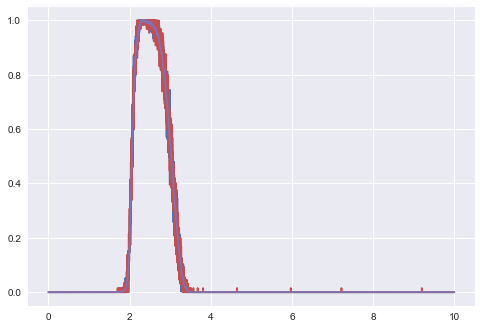

In [66]:
plt.plot(t, ops)
plt.plot(t, op)
plt.plot(t, ops_d/65)
plt.plot(t, op_d/65)
plt.show()
#plt.xlim(0, 6)

#plt.savefig('/Users/margotwagner/projects/DetailedMarkov/scripts/sde.png')
#plt.show()

# Markov

In [16]:
##########################
###### MARKOV DATA #######
##########################
def markov_sim(fname):
    N_CHANS=65
    sep_results_df = (pd.read_csv(file) for file in sorted(glob.glob(fname)))
    markov_results = pd.concat(sep_results_df)
    
    # Normalize
    for col_name in markov_results.columns[2:8]:
        markov_results['{}_norm'.format(col_name)] = markov_results[col_name]/N_CHANS
    
    
    # Average across trials
    avg_markov_results = markov_results.groupby('timepoints').mean()
    del avg_markov_results['trial']
    
    markov_results.head()
    
    return markov_results, avg_markov_results

In [17]:
fname = "../markov_data/markov_1000_runs*.csv"
markov_results, avg_markov_results = markov_sim(fname)

# Single Markov

In [18]:
# Simulate Markov process for stochastically opening and closing channels
def markov_vdcc_n(n_channels,trange,dt):
    '''
    Simulates a Markov process for the stochastic opening and closing of channels using
    multinomial sampling.
    
    @param n_channels (int) - number of channels to model
    @param trange (int/float array) - array over which the simulation takes place
    @param dt (int/float) - time step
    
    @return n_per_state (int array) - number of channels in each state at each time point (shape: [trange, n_states])
    @return ca (int array) - number of calcium that enters at each time point (shape: [trange])
    @return ca_sum (int array) - total sum of calcium that has entered at that time (shape: [trange])
    '''
    n_states = 5
    n_per_state = np.zeros((len(trange), n_states), dtype=int)
    ca = np.zeros(len(trange), dtype=int)
    ca_sum = np.zeros(len(trange), dtype=int)
    
    # All channels start in C0
    n_per_state[0,0] = n_channels
    
    for t_index in range(len(trange)-1):
        p_trans_0 = [1 - a1(trange[t_index])*dt, a1(trange[t_index])*dt, 0, 0, 0]
        samp0 = np.random.multinomial(n_per_state[t_index,0], p_trans_0)
        
        
        p_trans_1 = [b1(trange[t_index])*dt, 1 - (b1(trange[t_index])*dt + a2(trange[t_index])*dt), 
                           a2(trange[t_index])*dt, 0, 0]
        samp1 = np.random.multinomial(n_per_state[t_index,1], p_trans_1)
        
        
        p_trans_2 = [0, b2(trange[t_index])*dt, 1 - (b2(trange[t_index])*dt + a3(trange[t_index])*dt), 
                           a3(trange[t_index])*dt, 0]
        samp2 = np.random.multinomial(n_per_state[t_index,2], p_trans_2)
        
        
        p_trans_3 = [0, 0, b3(trange[t_index])*dt, 1 - (b3(trange[t_index])*dt + a4(trange[t_index])*dt), 
                           a4(trange[t_index])*dt]
        samp3 = np.random.multinomial(n_per_state[t_index,3], p_trans_3)
        
        
        p_trans_4 = [0, 0, 0, b4(trange[t_index])*dt, 1 - b4(trange[t_index])*dt]
        samp4 = np.random.multinomial(n_per_state[t_index,4], p_trans_4)
        
        ca[t_index+1] = np.random.binomial(n_per_state[t_index,4], k_ca(trange[t_index])*dt)
        ca_sum[t_index+1] = ca[t_index+1] + ca_sum[t_index]
        
        n_per_state[t_index+1,:] = samp0 + samp1 + samp2 + samp3 + samp4
        
    return n_per_state, ca, ca_sum
        

In [22]:
dt = 1e-3
t_start = 0
t_stop = 10
trange = np.arange(t_start, t_stop+dt, dt)
n_per_state, ca_markov, ca_sum_markov = markov_vdcc_n(65, trange, dt)

# Rerun all the Markov

In [22]:
# Constants
N_RUNS = 1000
N_VDCC_STATES = 5
N_CHANS = 65

# Time array
dt = 1e-3
trange = np.arange(0, 10+dt, dt)

# Initialize array sizes
ca = np.empty([len(trange), N_RUNS])
ca_sum = np.empty([len(trange), N_RUNS])
vdcc_states = np.empty([len(trange), N_VDCC_STATES, N_RUNS])

In [ ]:
# Run simulation
for i in range(N_RUNS):
    vdcc_states[:, :, i], ca[:, i], ca_sum[:, i] = markov_vdcc_n(N_CHANS, trange, dt)

In [ ]:
# trial number for each time point
trial = np.empty(N_RUNS*len(trange))

for run in range(N_RUNS):
    for tp in range(len(trange)):
        trial[len(trange)*run + tp] = run + 1
        
# repeat timepoints for each trial
timepoints = np.tile(trange, N_RUNS)

In [ ]:
results = pd.DataFrame(trial, columns=['trial'])
results['timepoints'] = timepoints
for i in range(4):
    results['vdcc_c{:d}'.format(i)] = vdcc_states[:, i, :].flatten('F')
results['vdcc_o'] = vdcc_states[:, 4, :].flatten('F')
results['ca_sum'] = ca_sum.flatten('F')
results['ca'] = ca.flatten('F')

In [ ]:
print(results.shape)
results.head()

In [ ]:
from math import ceil

MAX_STORE = 1000000

# Save data
for i in range(int(ceil(results.shape[0]/MAX_STORE))):
    # Save to csv
    results.iloc[i*MAX_STORE:(i+1)*MAX_STORE].to_csv('markov_1000_runs_take2_{:d}.csv'.format(i), index=False)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (20,20))

for a, col in zip(ax.flatten(), results.columns[2:]):
    #sns.relplot(x="timepoints", y=col, kind="line", ci="sd", data=results, ax=a)
    sns.lineplot(x="timepoints", y=col, ci="sd", data=results, ax=a)
    a.set_title(col, size=30)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Count', size=20)
    a.tick_params(labelsize=20)
 

for i in range(2,8): 
    plt.close(i)
    
plt.tight_layout()
plt.show()


# MCell

In [7]:
##########################
####### MCELL DATA #######
##########################
def mcell_sim(fname):
    SEEDS = 240
    DATA_DIM = 2
    T_START = 0
    ITERATIONS = 10000
    T_STEP = 1e-6
    T_STOP = ITERATIONS * T_STEP
    T_RANGE = np.arange(T_START, T_STOP + T_STEP / 2, T_STEP)
    
    # Molecule data file names (ie ca.World.dat)
    mol_files = []
    mol_names = []
    os.path.join(MCELL_DIR,"seed_00001/vdcc_pre_*.World.dat")
    files = sorted(glob.glob(os.path.join(MCELL_DIR,"seed_00001/vdcc_pre_*.World.dat")))
    files[4], files[5] = files[5], files[4]
    
    for file_path in files:
        mol_file = file_path.split('/')[-1]
        mol_files.append(mol_file)
        mol_names.append(mol_file.split('.')[0])
        
    # Initialize data arrays
    # Data is list of np arrays n_mol in length
    mcell_data = []
    for i in range(len(mol_files)):
        mcell_data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))
        # time x features (2 time, val) x seeds
    
    # Add data to all arrays
    for seed in range(SEEDS):
        for i in range(len(mol_files)):
            fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed + 1), mol_files[i])
            mcell_data[i][:, :, seed] = pd.read_csv(fname, delim_whitespace=True, header=None)
    
            
    mcell_results = np.copy(mcell_data)
    N_CHANS=65
    for i in range(len(mcell_results)):
        #if i != 5:
        mcell_results[i][:, 1, :] = mcell_results[i][:, 1, :] / N_CHANS
        
    return mcell_results

In [12]:
##########################
####### MCELL DATA #######
##########################
def mcell_sim_smaller_dt(fname, seeds=240, iterations=100000, t_step=1e-7):
    SEEDS = seeds
    DATA_DIM = 2
    T_START = 0
    ITERATIONS = iterations
    T_STEP = t_step
    T_STOP = ITERATIONS * T_STEP
    T_RANGE = np.arange(T_START, T_STOP + T_STEP / 2, T_STEP)
    
    # Molecule data file names (ie ca.World.dat)
    mol_files = []
    mol_names = []
    os.path.join(MCELL_DIR,"seed_00001/vdcc_pre_*.World.dat")
    files = sorted(glob.glob(os.path.join(MCELL_DIR,"seed_00001/vdcc_pre_*.World.dat")))
    files[4], files[5] = files[5], files[4]
    
    for file_path in files:
        mol_file = file_path.split('/')[-1]
        mol_files.append(mol_file)
        mol_names.append(mol_file.split('.')[0])
        
    # Initialize data arrays
    # Data is list of np arrays n_mol in length
    mcell_data = []
    for i in range(len(mol_files)):
        mcell_data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))
        # time x features (2 time, val) x seeds
    
    # Add data to all arrays
    for seed in range(SEEDS):
        for i in range(len(mol_files)):
            fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed + 1), mol_files[i])
            mcell_data[i][:, :, seed] = pd.read_csv(fname, delim_whitespace=True, header=None)
    
            
    mcell_results = np.copy(mcell_data)
    N_CHANS=65
    for i in range(len(mcell_results)):
        #if i != 5:
        mcell_results[i][:, 1, :] = mcell_results[i][:, 1, :] / N_CHANS
        
    return mcell_results

In [8]:
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/" \
            "final_model_122820/model_1_vdcceqtns_tchange_files/" \
            "mcell/output_data/react_data/"
mcell_results = mcell_sim(MCELL_DIR)

In [14]:
#MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model_1/" \
#            "model_1_vdcceqtns_tchange_nodendrite_files/mcell/output_data/" \
#            "react_data/"

# USE THIS ONE! (n_seeds = 240)
#MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/" \
#            "final_model_122820/model_1_vdcceqtns_tchange_files/" \
#            "mcell/output_data/react_data/"

MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model_1/model_1_vdcceqtns_tchange_smaller_dt_files/" \
            "mcell/output_data/react_data/"

#MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model_1/model_1_vdcceqtns_tchange_files/mcell/output_data/react_data/"

mcell_results_2 = mcell_sim_smaller_dt(MCELL_DIR)

In [15]:
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model_1/model_1_vdcceqtns_tchange_e8_dt_files/" \
            "mcell/output_data/react_data/"

mcell_results_3 = mcell_sim_smaller_dt(fname, seeds=79, iterations=1000000, t_step=1e-8)

In [36]:
len(mcell_results[0])

10001

In [37]:
len(mcell_results_2[0])

100001

# Plotting

In [10]:
def all_vdcc_plot(odesolve=False, euler=False, mcell=False, markov=False, incl_std=False):
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
    
    names = markov_results.columns[9:].values
    
    t_offset = 1.5
    lwidth = 3
    
    ##########
    # MARKOV #
    ##########
    if markov == True:
        if incl_std == False:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=lwidth, ax=a)
        else:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(markov_results["timepoints"], y=n, data=markov_results, 
                             ci="sd", linewidth=lwidth, ax=a, label="Markov")

    for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
        #########
        # MCELL #
        #########
        if mcell == True:
            
            mcell_color = 'C3'
            mcell_mean = np.mean(mcell_results[i], axis=2)
            mcell_std = np.std(mcell_results[i], axis=2)
            
            # Plot mean
            a.plot(mcell_mean[:,0]*1000, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label='MCell')
 
            # Cloud plot for std dev
            if incl_std == True:
                a.fill_between(mcell_mean[:,0]*1000, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                               np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color)    
                
         
    for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
        ##############
        # ODE SOLVER #
        ##############
        if odesolve == True:
            if i != 5: # Ca variance is negative?
                ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])  
                ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
                
                # Cloud plot for sd
                if incl_std == True:
                    a.fill_between(ode_results.t, np.add(ode_results.y[i,:], ode_sd), 
                                   np.subtract(ode_results.y[i,:], ode_sd),alpha=0.5, color='lightgrey')
                
            a.plot(ode_results.t,ode_results.y[i], color='black', linewidth=lwidth, label="ODE") 
             
        
    # EULER
    #if euler == True:
    #    ax[0,0].plot(trange, vdcc_c0, color='g')
    #    ax[0,1].plot(trange, vdcc_c1, color='g')
    #    ax[1,0].plot(trange, vdcc_c2, color='g')
    #    ax[1,1].plot(trange, vdcc_c3, color='g')
    #    ax[2,0].plot(trange, vdcc_o, color='g')
    #    ax[2,1].plot(trange, ca, color='g')
    #    
    
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    states = ['C0', 'C1', 'C2', 'C3', 'O', '']
    for a, i in zip(ax.flatten(), range(len(states))):
        a.set_xlim(0, 5)
        a.tick_params(labelsize=20)
        a.set_xlabel('time (ms)', fontsize=26)
        a.legend(prop={"size":20})
        a.set_ylabel('fraction of VDCCs ({})'.format(states[i]), fontsize=26)
        
    ax[2,1].set_ylabel('calcium influx per open vdcc'.format(states[i]), fontsize=26)
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_all.png')
    plt.show()

#all_vdcc_plot(odesolve=True, euler=False, mcell=True, markov=True, incl_std=True)

In [12]:
def close_up():
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(2, 1, figsize = (12,20), dpi=200)
    N_CHANS = 65
    
    names = markov_results.columns[13:].values

    for a, i in zip(ax.flatten(), range(4,6)):
        #########
        # MCELL #
        #########
            
        mcell_color = 'C3'
        mcell_mean = np.mean(mcell_results[i], axis=2)
        mcell_std = np.std(mcell_results[i], axis=2)
        
        # Plot mean
        a.plot(mcell_mean[:,0]*1000, mcell_mean[:,1], color=mcell_color, linewidth=2)
        
        # Cloud plot for std dev
        a.fill_between(mcell_mean[:,0]*1000, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                       np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color)    
            
            
        ##############
        # ODE SOLVER #
        ##############
        if i != 5: # Ca variance is negative?
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])  
            ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
            
            # Cloud plot for sd
            a.fill_between(ode_results.t, np.add(ode_results.y[i,:], ode_sd), 
                           np.subtract(ode_results.y[i,:], ode_sd),alpha=0.5, color='lightgrey')
            
        a.plot(ode_results.t,ode_results.y[i], color='black', linewidth=2) 
        
    ##########
    # MARKOV #
    ##########
    for a, n in zip(ax.flatten(), names):
        sns.lineplot(x="timepoints", y=n, data=markov_results, ci="sd", linewidth=2, ax=a)
         
    
    for a in ax.flatten():
        a.set_xlim(1, 4.5)
        a.tick_params(labelsize=10)
    plt.show()

# Difference Figure

In [28]:
def vdcc_plot_diff(mcell_plot=False, markov_plot=False):
    '''
    Plot the difference between the ODe and stochastic dynamics curves
    
    '''
    fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
        
    names = markov_results.columns[9:].values 
        
    #########
    # MCELL #
    #########
    if mcell_plot == True:
        for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            # MCell mean
            mean = np.mean(mcell_results[i], axis=2)
            
            
            # Subtract stochastic from ode
            if i == 5:
                a.plot(ode_results.t, 65*(ode_results.y[i] - mean[:,1]))
            else:
                a.plot(ode_results.t, ode_results.y[i] - mean[:,1])
            
        
    ##########
    # MARKOV #
    ########## 
    if markov_plot == True:
        i = 0
        for a, n in zip(ax.flatten(), names):
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            # Markov
            #sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=1, ax=a, color='r')
            
            # ode
            #a.plot(ode_results.t, ode_results.y[i], color='black')
            
            if n == 'ca_sum_norm':
                a.plot(ode_results.t, 65*(ode_results.y[i] - np.asarray(avg_markov_results[n])))
            else:
                a.plot(ode_results.t, ode_results.y[i] - np.asarray(avg_markov_results[n]))
                   
            i += 1
            
            a.set_title('difference between ode and stochastic simulations, {}'.format(n))
            a.set_xlabel('time')
            a.set_ylabel('difference')
            
    ax[2,1].set_title('difference between ode and stochastic simulations, ca for 65 channels')
            
    plt.show()

In [25]:
#vdcc_plot_diff(mcell_plot=True, markov_plot=True)

In [30]:
def ibm_diff_plot():
    '''
    Plot the difference between the ODe and stochastic dynamics curves
    
    '''
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(2, 1, figsize = (12,20), dpi=200)
    N_CHANS = 65
        
    names = markov_results.columns[13:].values 
        
    #########
    # MCELL #
    #########
    for a, i in zip(ax.flatten(), range(4,6)):
        mcell_color = 'C3'
        
        # Replace negatives with zero
        ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
        
        # MCell mean
        mean = np.mean(mcell_results[i], axis=2)
        
        
        # Subtract stochastic from ode
        #if i == 5:
        #    a.plot(ode_results.t, 65*(ode_results.y[i] - mean[:,1]))
        #else:
        a.plot(ode_results.t, ode_results.y[i] - mean[:,1], color=mcell_color, linewidth=2)
            
        
    ##########
    # MARKOV #
    ########## 
    i = 4
    for a, n in zip(ax.flatten(), names):
        # Replace negatives with zero
        ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
        
        # Markov
        #sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=1, ax=a, color='r')
        
        # ode
        #a.plot(ode_results.t, ode_results.y[i], color='black')
        
        if n == 'ca_sum_norm':
            a.plot(ode_results.t, (ode_results.y[i] - np.asarray(avg_markov_results[n])), color='C0', linewidth=2)
        else:
            a.plot(ode_results.t, ode_results.y[i] - np.asarray(avg_markov_results[n]), color='C0', linewidth=2)
               
        i += 1
        
        a.set_title('difference between ode and stochastic simulations, {}'.format(n))
        a.set_xlabel('time')
        a.set_ylabel('difference')
            
    #ax[2,1].set_title('difference between ode and stochastic simulations, ca for 65 channels')
    
    for a in ax.flatten():
        a.set_xlim(1, 4.5)
        #a.tick_params(labelsize=10)
            
    plt.show()

# Paper Figs

In [13]:
def open_vdccs():
    '''
    Plot open vdcc's across all simulations and difference from ODE
    '''
    t_offset = 1.5
    lwidth = 3
    vdcc_i = 4
    
    
    with plt.style.context('seaborn'):
        plt.figure(figsize = (10,7), dpi=200)
    N_CHANS = 65
    
    #name = markov_results.columns[13:14].values
    name = 'vdcc_o_norm'
    
    #########
    #  ODE  #
    #########
    # BLACK
    # replace negative with zero
    ode_results.y[4] = np.where(ode_results.y[vdcc_i]<0, 0, ode_results.y[vdcc_i])  
    plt.plot(ode_results.t - t_offset,ode_results.y[vdcc_i], color='black', linewidth=lwidth, label="ODE") 
    
    ode_sd = np.sqrt(np.multiply(ode_results.y[vdcc_i,:], (1 - ode_results.y[vdcc_i,:]))/N_CHANS)
    
    # Cloud plot for sd
    plt.fill_between(ode_results.t - t_offset, np.add(ode_results.y[vdcc_i,:], ode_sd), 
                   np.subtract(ode_results.y[vdcc_i,:], ode_sd),alpha=0.5, color='lightgrey')

    
    #########
    # MCELL #
    #########
    # RED
    mcell_color = 'red'
    mcell_mean = np.mean(mcell_results[vdcc_i], axis=2)
    mcell_std = np.std(mcell_results[vdcc_i], axis=2)
    
    # Plot mean
    plt.plot(mcell_mean[:,0]*1000 - t_offset, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label="MCell",
            alpha=0.6)
    
    # Cloud plot for std dev
    plt.fill_between(mcell_mean[:,0]*1000 - t_offset, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                   np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
    
        
    ###########
    ## MARKOV #
    ###########
    # BLUE
    sns.lineplot(markov_results["timepoints"] - t_offset, y=name, data=markov_results, ci="sd", 
                 linewidth=lwidth, label="Markov")
    
    #plt.plot(ode_results.t - t_offset,n_per_state[:,4]/65, label='O', color="darkorange")
    

    
    #########
    #  SDE  #
    #########
    #ax[0].plot(ode_results.t - t_offset, ops, color='turquoise', linewidth=lwidth, label="SDE") 
    # INCLUDE STD DEV CLOUD
    #plt.plot(ode_results.t - t_offset, op, color='forestgreen', linewidth=lwidth, label="SDE mean") 
    #sde_sd = np.sqrt(np.multiply(op, (1 - op))/N_CHANS)
    #plt.fill_between(ode_results.t - t_offset, np.add(op, sde_sd), 
    #               np.subtract(op, sde_sd),alpha=0.3, color='forestgreen')
    
    
    # Poisson
    #sns.lineplot(poisson_results["timepoints"] - t_offset, y=name, data=poisson_results, ci="sd", 
    #             linewidth=lwidth, label="Poisson", color='aqua')
    #plt.plot(ode_results.t - t_offset, op_p/65, color='aqua', linewidth=lwidth, label="Poisson") 
    
    # INCLUDE STD DEV CLOUD
    #plt.plot(ode_results.t - t_offset, op_d/65, color='mediumorchid', linewidth=lwidth, label="Disc SDE mean")     
    
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    plt.xlim(0, 2.5)
    plt.tick_params(labelsize=20)
    plt.ylabel('fraction of open VDCCs', fontsize=26)
    plt.xlabel('time (ms)', fontsize=26)
    plt.legend(prop={"size":20})

    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_sde.png')
    plt.show()
    
open_vdccs()
    

NameError: name 'ode_results' is not defined

<Figure size 2000x1400 with 0 Axes>

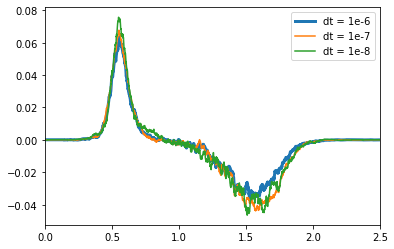

In [87]:
mcell_mean = np.mean(mcell_results[4], axis=2)
plt.plot(ode_results.t - 1.5, ode_results.y[4] - mcell_mean[:,1], color='C0', 
           linewidth=lwidth, label = 'dt = 1e-6')

mcell_mean_sdt = np.mean(mcell_results_2[4], axis=2)
small_dt_mcell_vdcc = mcell_mean_sdt[:-1][:,1]
ode_vdcc = ode_results.y[4][:-1]
diff = []
for i in range(len(ode_vdcc)):
    diff.append(ode_vdcc[i] - small_dt_mcell_vdcc[int(i*(len(small_dt_mcell_vdcc)/len(ode_vdcc)))])
plt.plot(ode_results.t[:-1] - 1.5, diff, color='C1', label = 'dt = 1e-7')
    
mcell_mean_e8dt = np.mean(mcell_results_3[4], axis=2)
e8_dt_mcell_vdcc = mcell_mean_e8dt[:-1][:,1]
diff = []
for i in range(len(ode_vdcc)):
    diff.append(ode_vdcc[i] - e8_dt_mcell_vdcc[int(i*(len(e8_dt_mcell_vdcc)/len(ode_vdcc)))])
plt.plot(ode_results.t[:-1] - 1.5, diff, color='C2', label = 'dt = 1e-8')
    

plt.xlim(0, 2.5)
plt.legend()
plt.show()

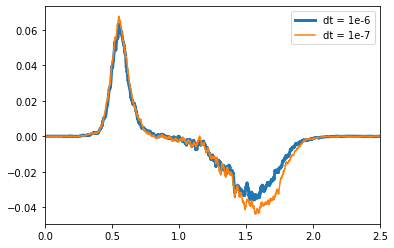

In [82]:
mcell_mean = np.mean(mcell_results[4], axis=2)
plt.plot(ode_results.t - 1.5, ode_results.y[4] - mcell_mean[:,1], color='C0', 
           linewidth=lwidth, label = 'dt = 1e-6')

mcell_mean_sdt = np.mean(mcell_results_2[4], axis=2)

small_dt_mcell_vdcc = mcell_mean_sdt[:-1][:,1]
ode_vdcc = ode_results.y[4][:-1]

diff = []
for i in range(len(ode_vdcc)):
    diff.append(ode_vdcc[i] - small_dt_mcell_vdcc[int(i*(len(small_dt_mcell_vdcc)/len(ode_vdcc)))])
    
plt.plot(ode_results.t[:-1] - 1.5, diff, color='C1', label = 'dt = 1e-7')
plt.xlim(0, 2.5)
plt.legend()
plt.show()

In [ ]:
for i in range(len(ode_results.t[:-1])):
    print(ode_results.y[4][i])
    print(mcell_mean[:,1][i*int(len(mcell_mean_sdt[:-1])/len(ode_results.t[:-1]))])
    diff.append(ode_results.y[4][i] - mcell_mean[:,1][i*int(len(mcell_mean_sdt[:-1])/len(ode_results.t[:-1]))])

plt.plot(ode_results.t - 1.5, diff, color='C3', linewidth=lwidth, label = '(ODE $-$ MCell)')


NameError: name 'ode_results' is not defined

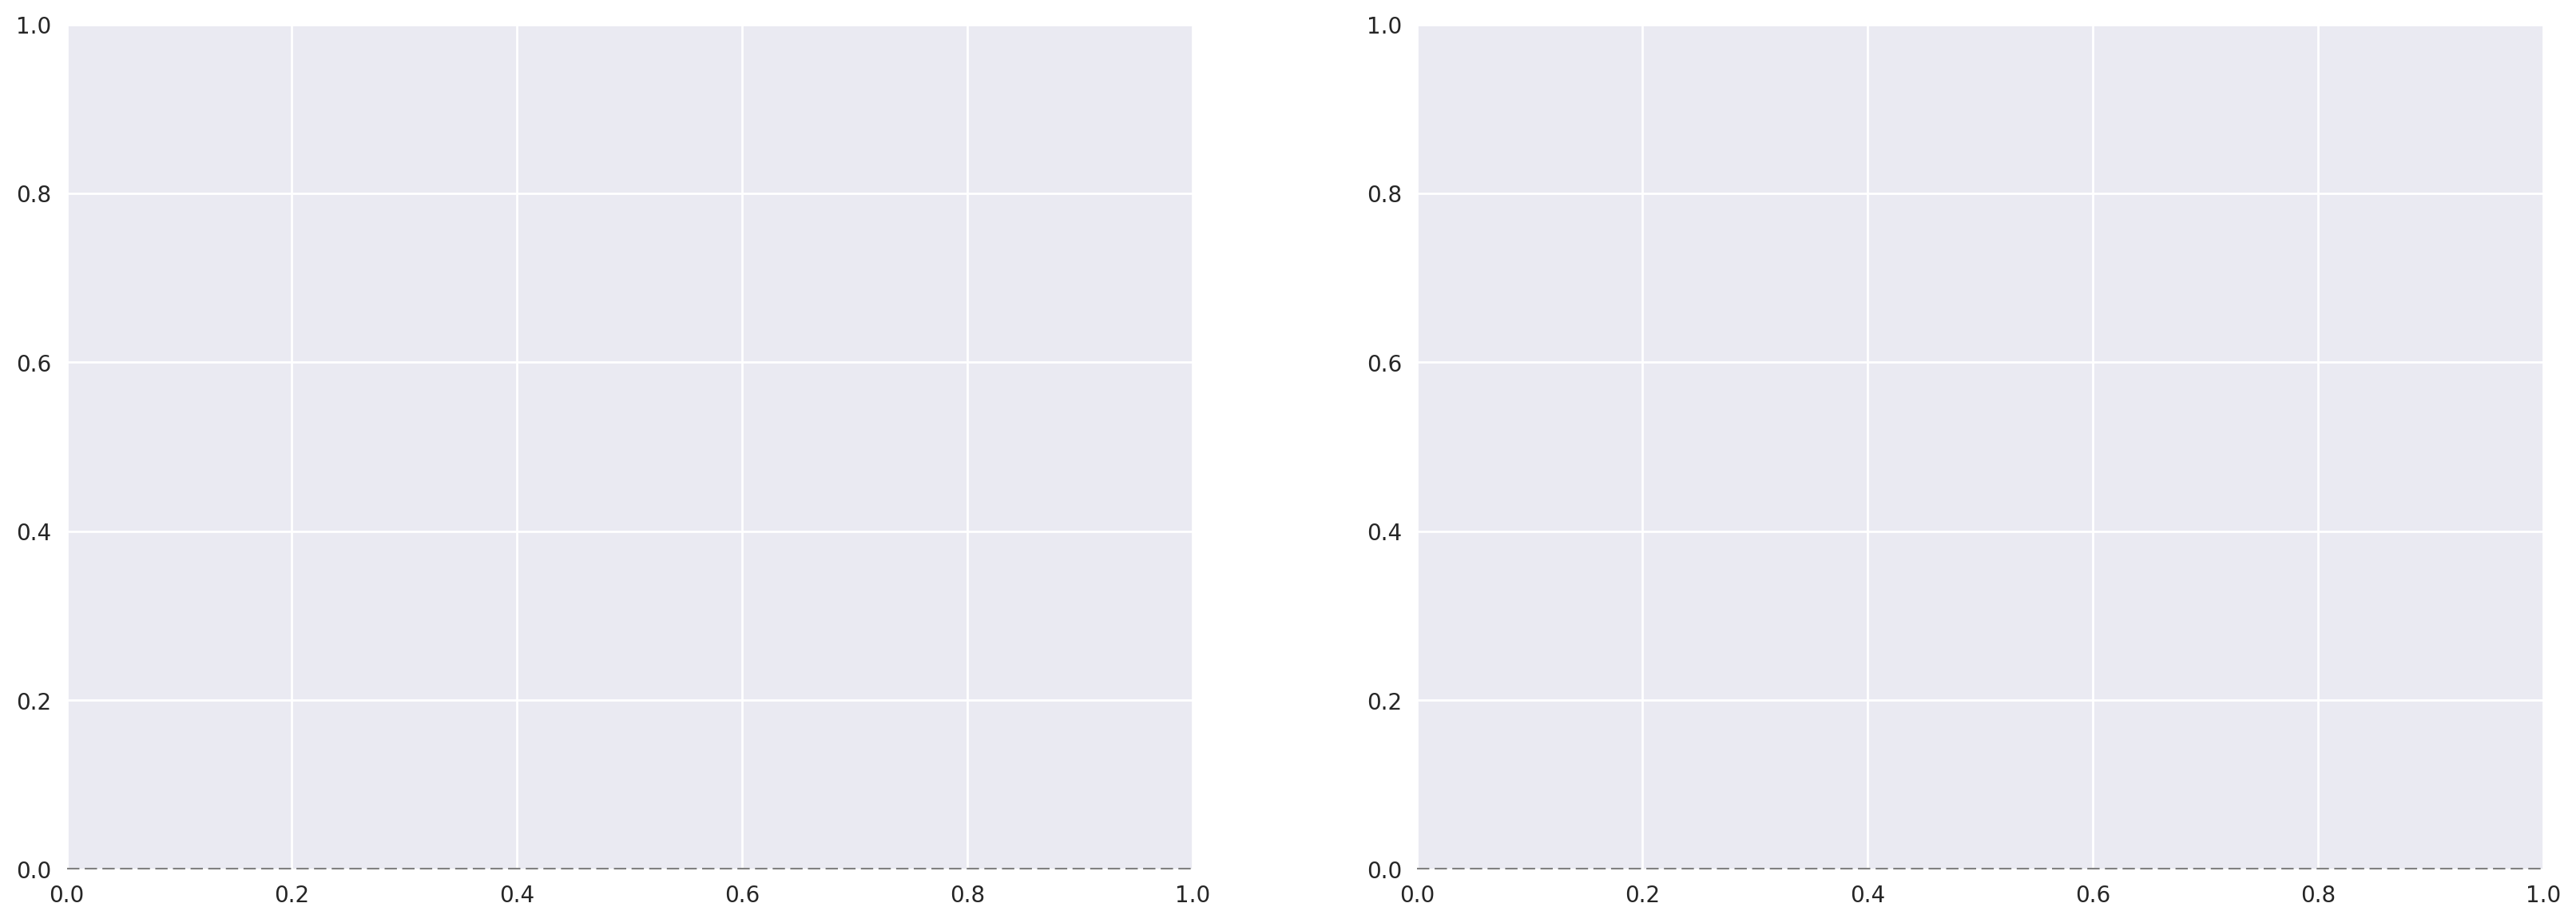

In [14]:
def open_vdccs():
    '''
    Plot open vdcc's across all simulations and difference from ODE
    '''
    t_offset = 1.5
    lwidth = 3
    vdcc_i = 4
    
    #fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    N_CHANS = 65
    
    #name = markov_results.columns[13:14].values
    name = 'vdcc_o_norm'
    
    ax[0].axhline(xmax=2.5, color="grey", linestyle="--")
    ax[1].axhline(xmax=2.5, color="grey", linestyle="--")
    
    #########
    #  ODE  #
    #########
    # BLACK
    # replace negative with zero
    ode_results.y[4] = np.where(ode_results.y[vdcc_i]<0, 0, ode_results.y[vdcc_i])  

    ax[0].plot(ode_results.t - t_offset,ode_results.y[vdcc_i], color='black', linewidth=lwidth, label="ODE") 
    
    ode_sd = np.sqrt(np.multiply(ode_results.y[vdcc_i,:], (1 - ode_results.y[vdcc_i,:]))/N_CHANS)
    
    # Cloud plot for sd
    ax[0].fill_between(ode_results.t - t_offset, np.add(ode_results.y[vdcc_i,:], ode_sd), 
                   np.subtract(ode_results.y[vdcc_i,:], ode_sd),alpha=0.5, color='lightgrey')

    
    #########
    # MCELL #
    #########
    # RED
    mcell_color = 'C3'
    mcell_mean = np.mean(mcell_results[vdcc_i], axis=2)
    mcell_std = np.std(mcell_results[vdcc_i], axis=2)
    
    # Plot mean
    ax[0].plot(mcell_mean[:,0]*1000 - t_offset, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label="MCell")
    
    # Cloud plot for std dev
    ax[0].fill_between(mcell_mean[:,0]*1000 - t_offset, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                   np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
    

    
    # Subtract MCell from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - mcell_mean[:,1], color=mcell_color, 
               linewidth=lwidth, label = '(ODE $-$ MCell)')
    
        
    ###########
    ## MARKOV #
    ###########
    # BLUE
    sns.lineplot(markov_results["timepoints"] - t_offset, y=name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[0], label="Markov")
    
    # Subtract Markov from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - np.asarray(avg_markov_results[name]), 
               color='C0', linewidth=lwidth, label = '(ODE $-$ Markov)')
    
            # subtract stochastic simulations
    ax[1].plot(ode_results.t - t_offset, np.asarray(avg_markov_results[name]) - mcell_mean[:,1], 
               color='grey', linewidth=lwidth, label = '(Markov $-$ MCell)')
    

    

    
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    ax[0].set_xlim(0, 2.5)
    #ax[0].set_ylim(0, 1.2)
    ax[0].tick_params(labelsize=20)
    ax[0].set_ylabel('fraction of open VDCCs', fontsize=26)
    ax[0].set_xlabel('time (ms)', fontsize=26)
    ax[0].legend(prop={"size":20})
    
    ax[1].set_ylim(-0.05, 0.25)
    ax[1].set_xlim(0, 2.5)
    ax[1].tick_params(labelsize=20)
    ax[1].set_ylabel('difference in open VDCCs', fontsize=26)
    ax[1].set_xlabel('time (ms)', fontsize=26)
    ax[1].legend(prop={"size":20})
    
    ax[0].text(-0.15, 1, "A", transform=ax[0].transAxes, size=30, weight='bold')
    ax[0].text(-0.25, 1, "B", transform=ax[1].transAxes, size=30, weight='bold')
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc.png')
    plt.show()
    
open_vdccs()

/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


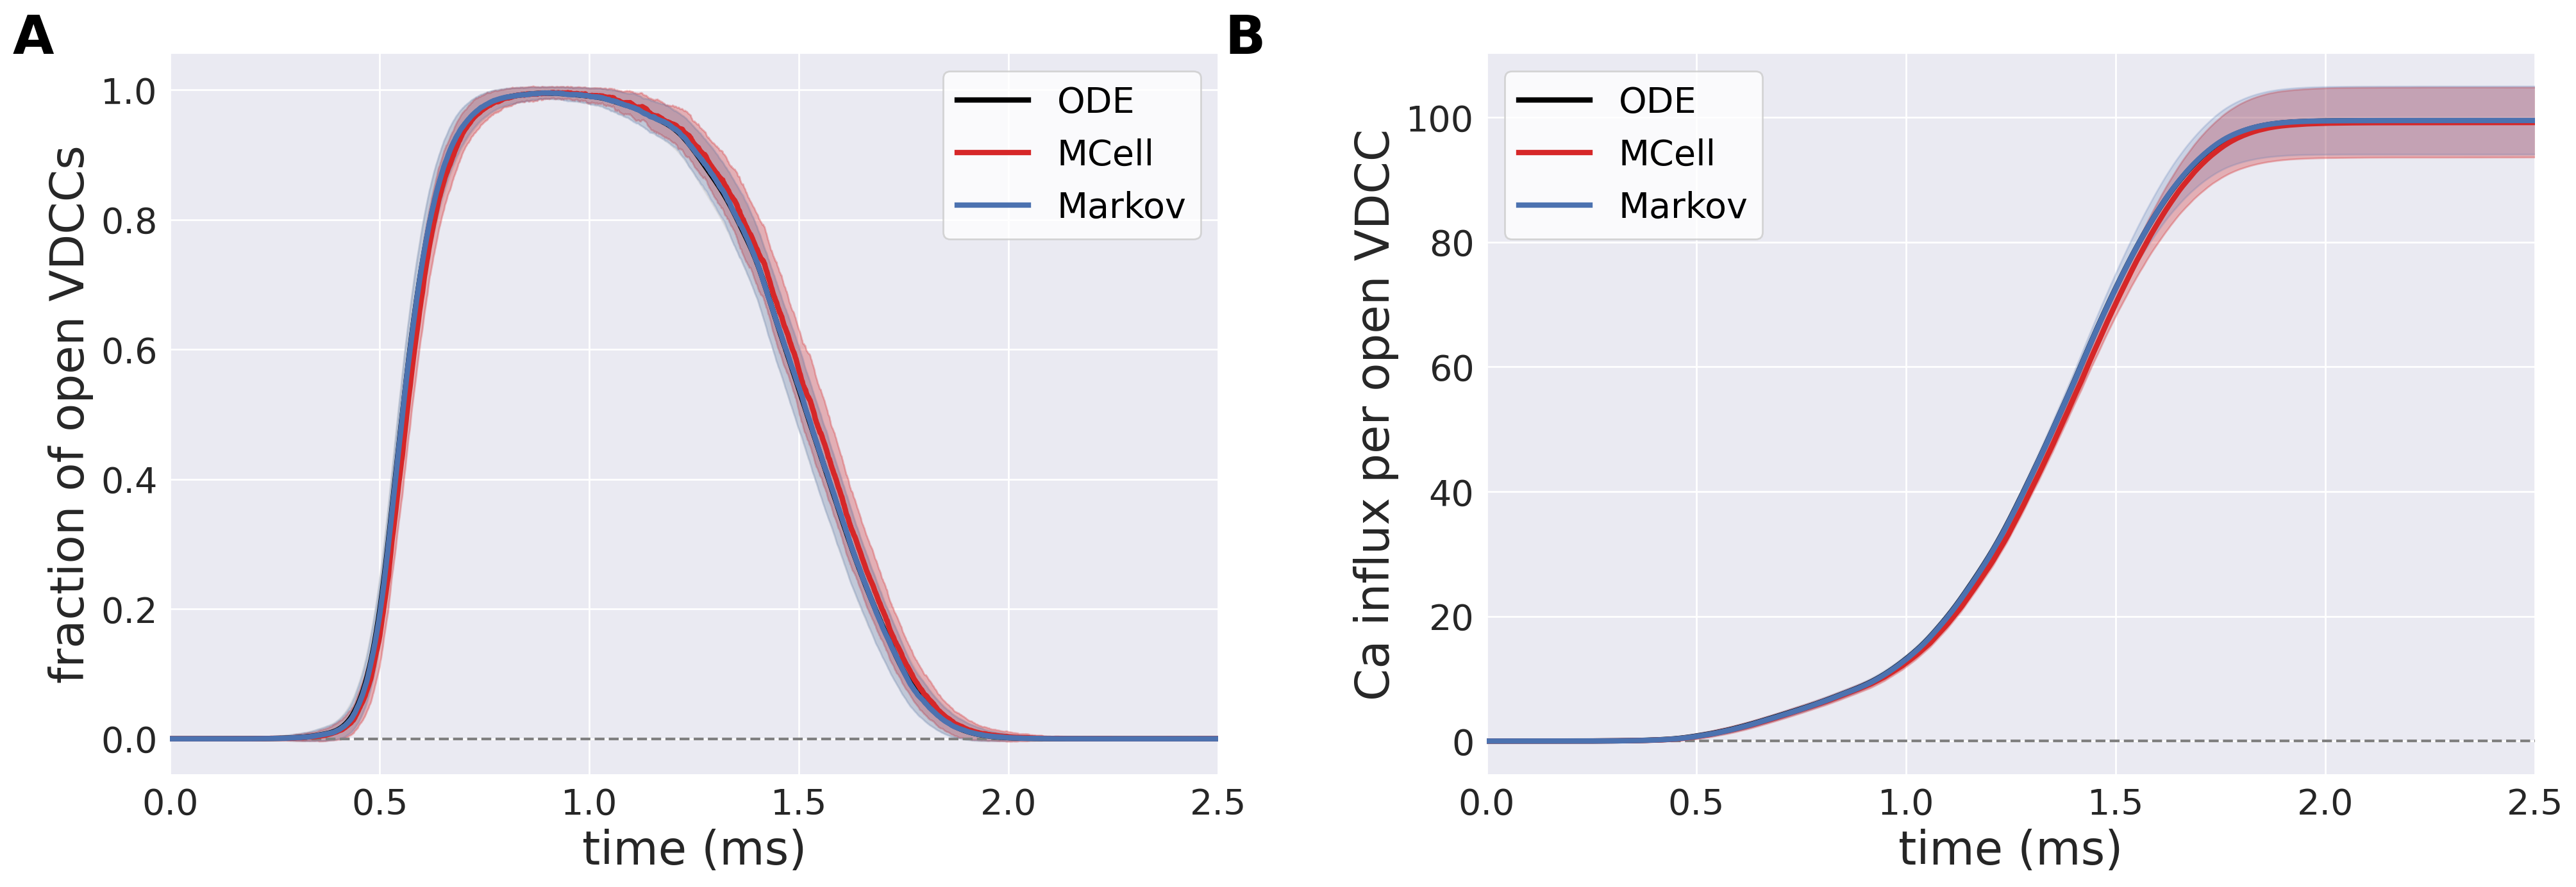

In [16]:
def vdcc_results():
    '''
    Plot open vdcc's across all simulations and difference from ODE
    '''
    t_offset = 1.5
    lwidth = 3
    vdcc_i = 4
    ca_i = 5
    
    #fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    N_CHANS = 65

    name = 'vdcc_o_norm'
    ca_name = 'ca_sum_norm'
    
    ax[0].axhline(xmax=2.5, color="grey", linestyle="--")
    ax[1].axhline(xmax=2.5, color="grey", linestyle="--")
    
    #########
    #  ODE  #
    #########
    # BLACK
    # open vdccs
    # replace negative with zero
    ode_results.y[4] = np.where(ode_results.y[vdcc_i]<0, 0, ode_results.y[vdcc_i])  

    ax[0].plot(ode_results.t - t_offset,ode_results.y[vdcc_i], color='black', linewidth=lwidth, label="ODE") 
    
    ode_sd = np.sqrt(np.multiply(ode_results.y[vdcc_i,:], (1 - ode_results.y[vdcc_i,:]))/N_CHANS)
    
    # Cloud plot for sd
    ax[0].fill_between(ode_results.t - t_offset, np.add(ode_results.y[vdcc_i,:], ode_sd), 
                   np.subtract(ode_results.y[vdcc_i,:], ode_sd),alpha=0.5, color='lightgrey')
    
    # calcium
    ode_results.y[ca_i] = np.where(ode_results.y[ca_i]<0, 0, ode_results.y[ca_i])  

    ax[1].plot(ode_results.t - t_offset,ode_results.y[ca_i], color='black', linewidth=lwidth, label="ODE") 
    

    
    #########
    # MCELL #
    #########
    # RED
    # Open VDCCs
    mcell_color = 'C3'
    mcell_mean = np.mean(mcell_results[vdcc_i], axis=2)
    mcell_std = np.std(mcell_results[vdcc_i], axis=2)
    
    # Plot mean
    ax[0].plot(mcell_mean[:,0]*1000 - t_offset, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label="MCell")
    
    # Cloud plot for std dev
    ax[0].fill_between(mcell_mean[:,0]*1000 - t_offset, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                   np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color)
    
    # Calcium
    mcell_color = 'C3'
    mcell_mean = np.mean(mcell_results[ca_i], axis=2)
    mcell_std = np.std(mcell_results[ca_i], axis=2)
    
    # Plot mean
    ax[1].plot(mcell_mean[:,0]*1000 - t_offset, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label="MCell")
    
    # Cloud plot for std dev
    ax[1].fill_between(mcell_mean[:,0]*1000 - t_offset, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                   np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
    
    
        
    ###########
    ## MARKOV #
    ###########
    # BLUE
    # Open VDCCs
    sns.lineplot(markov_results["timepoints"] - t_offset, y=name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[0], label="Markov")
    
    # Calcium
    sns.lineplot(markov_results["timepoints"] - t_offset, y=ca_name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[1], label="Markov")
    
    

    
    #####################
    # PLOTTING SETTINGS #
    #####################
    ax[0].set_xlim(0, 2.5)
    ax[0].tick_params(labelsize=20)
    ax[0].set_ylabel('fraction of open VDCCs', fontsize=26)
    ax[0].set_xlabel('time (ms)', fontsize=26)
    ax[0].legend(prop={"size":20})
    
    ax[1].set_xlim(0, 2.5)
    ax[1].tick_params(labelsize=20)
    ax[1].set_ylabel('Ca influx per open VDCC', fontsize=26)
    ax[1].set_xlabel('time (ms)', fontsize=26)
    ax[1].legend(prop={"size":20})
    
    
    ax[0].text(-0.15, 1, "A", transform=ax[0].transAxes, size=30, weight='bold')
    ax[0].text(-0.25, 1, "B", transform=ax[1].transAxes, size=30, weight='bold')
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/both_vdcc_results.png')
    plt.show()
    
vdcc_results()

/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


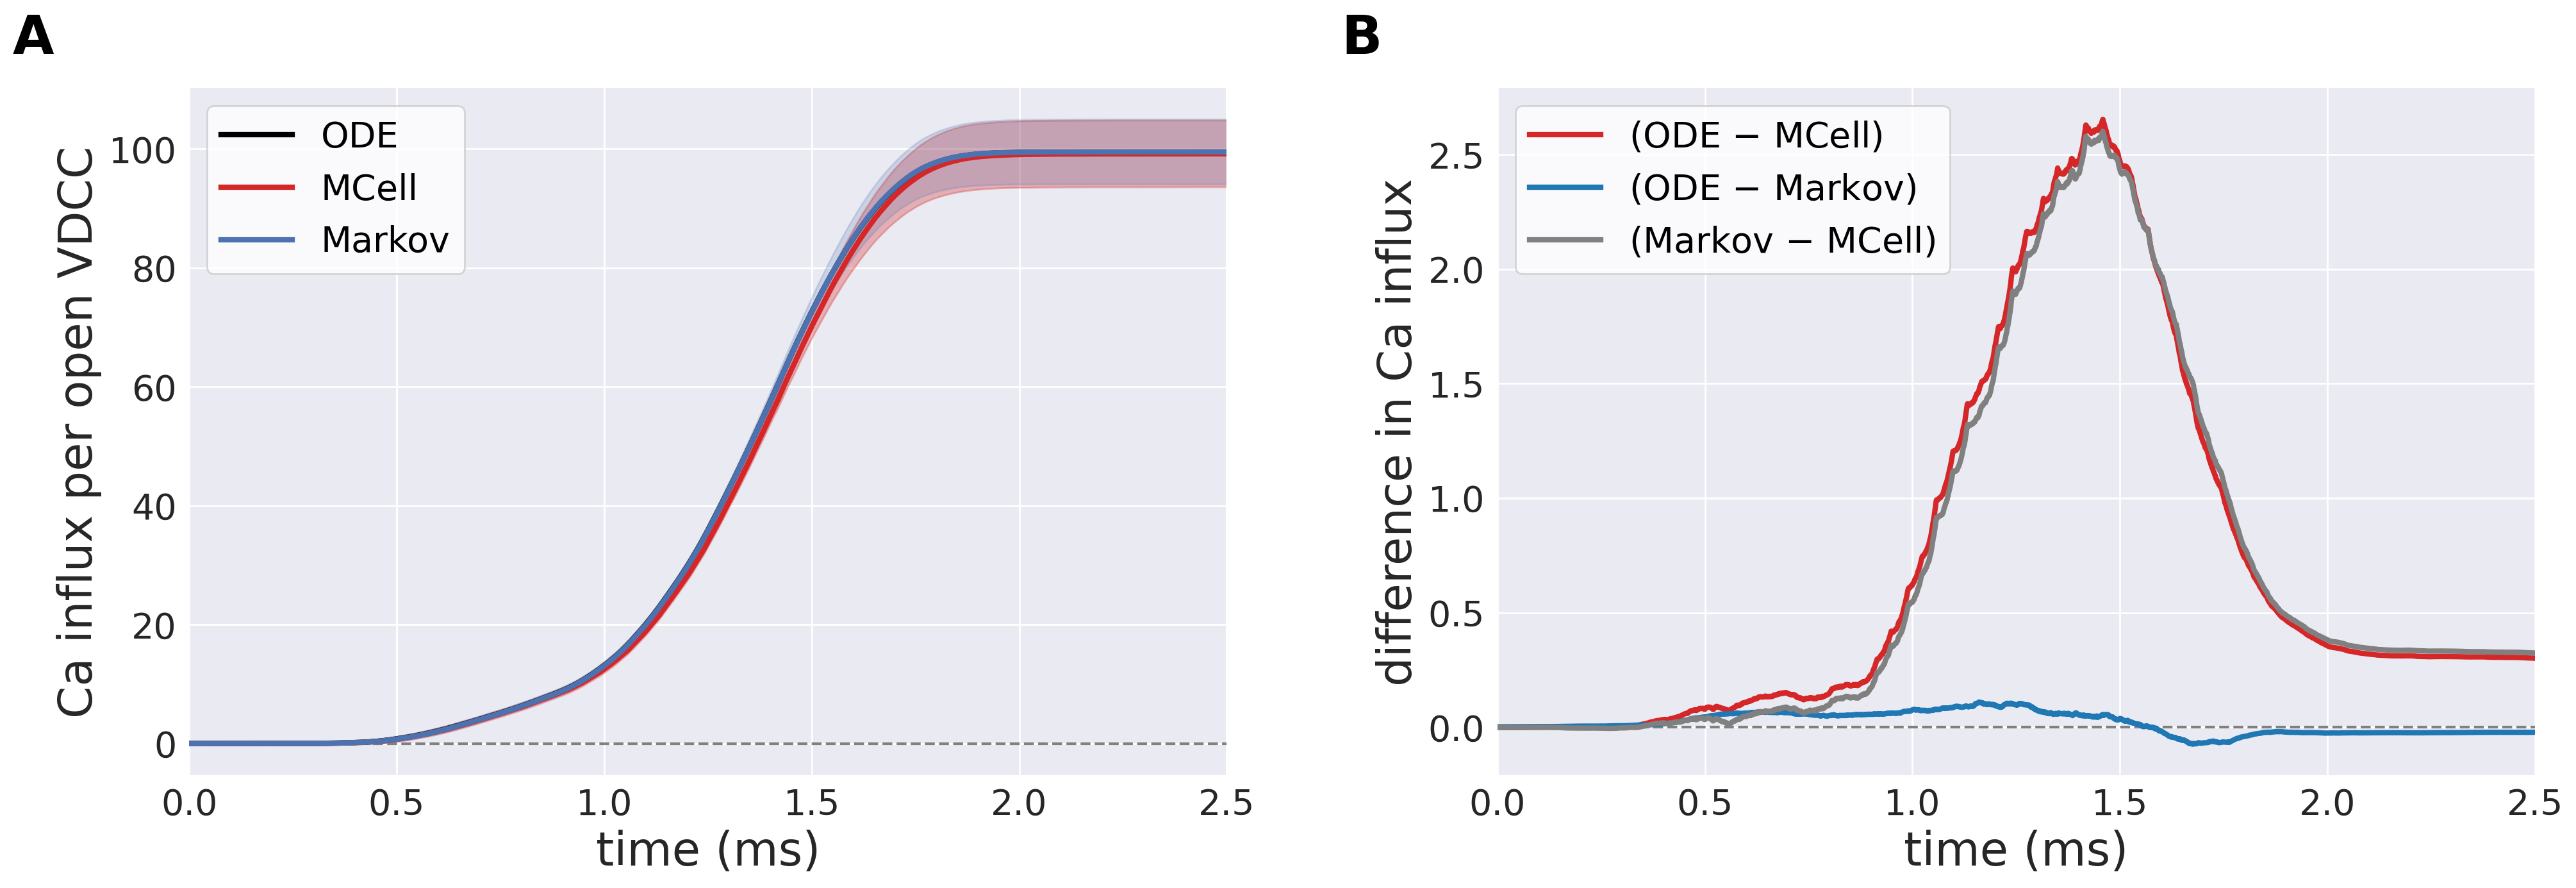

In [16]:
def ca_fig():
    '''
    Plot open vdcc's across all simulations and difference from ODE
    '''
    t_offset = 1.5
    lwidth = 3
    vdcc_i = 5
    
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    N_CHANS = 65
    
    name = 'ca_sum_norm'
    
    ax[0].axhline(xmax=2.5, color="grey", linestyle="--")
    ax[1].axhline(xmax=2.5, color="grey", linestyle="--")
    
    #########
    #  ODE  #
    #########
    # BLACK
    # replace negative with zero
    ode_results.y[vdcc_i] = np.where(ode_results.y[vdcc_i]<0, 0, ode_results.y[vdcc_i])  

    ax[0].plot(ode_results.t - t_offset,ode_results.y[vdcc_i], color='black', linewidth=lwidth, label="ODE") 
    

    #########
    #  SDE  #
    #########
    #ax[0].plot(ode_results.t - t_offset, ca, color='turquoise', linewidth=lwidth, label="SDE") 
    
    #########
    # MCELL #
    #########
    # RED
    mcell_color = 'C3'
    mcell_mean = np.mean(mcell_results[vdcc_i], axis=2)
    mcell_std = np.std(mcell_results[vdcc_i], axis=2)
    
    # Plot mean
    ax[0].plot(mcell_mean[:,0]*1000 - t_offset, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label="MCell")
    
    # Cloud plot for std dev
    ax[0].fill_between(mcell_mean[:,0]*1000 - t_offset, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                   np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
    

    
    # Subtract MCell from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - mcell_mean[:,1], color=mcell_color, 
               linewidth=lwidth, label = '(ODE $-$ MCell)')
    
        
    ###########
    ## MARKOV #
    ###########
    # BLUE
    sns.lineplot(markov_results["timepoints"] - t_offset, y=name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[0], label="Markov")
    
    # Subtract Markov from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - np.asarray(avg_markov_results[name]), 
               color='C0', linewidth=lwidth, label = '(ODE $-$ Markov)')
    
        # subtract stochastic simulations
    ax[1].plot(ode_results.t - t_offset, np.asarray(avg_markov_results[name]) - mcell_mean[:,1], 
               color='grey', linewidth=lwidth, label = '(Markov $-$ MCell)')
    
    
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    ax[0].set_xlim(0, 2.5)
    ax[0].tick_params(labelsize=20)
    ax[0].set_ylabel('Ca influx per open VDCC', fontsize=26)
    ax[0].set_xlabel('time (ms)', fontsize=26)
    ax[0].legend(prop={"size":20})
    
    ax[1].set_xlim(0, 2.5)
    ax[1].tick_params(labelsize=20)
    ax[1].set_ylabel('difference in Ca influx', fontsize=26)
    ax[1].set_xlabel('time (ms)', fontsize=26)
    ax[1].legend(prop={"size":20})
    
    ax[0].text(-0.17, 1.05, "A", transform=ax[0].transAxes, size=30, weight='bold')
    ax[1].text(-0.15, 1.05, "B", transform=ax[1].transAxes, size=30, weight='bold')
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_ca.png')
    plt.show()
    
ca_fig()

<ipython-input-17-02243a0f28e4>:18: RuntimeWarning: invalid value encountered in sqrt
  ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword

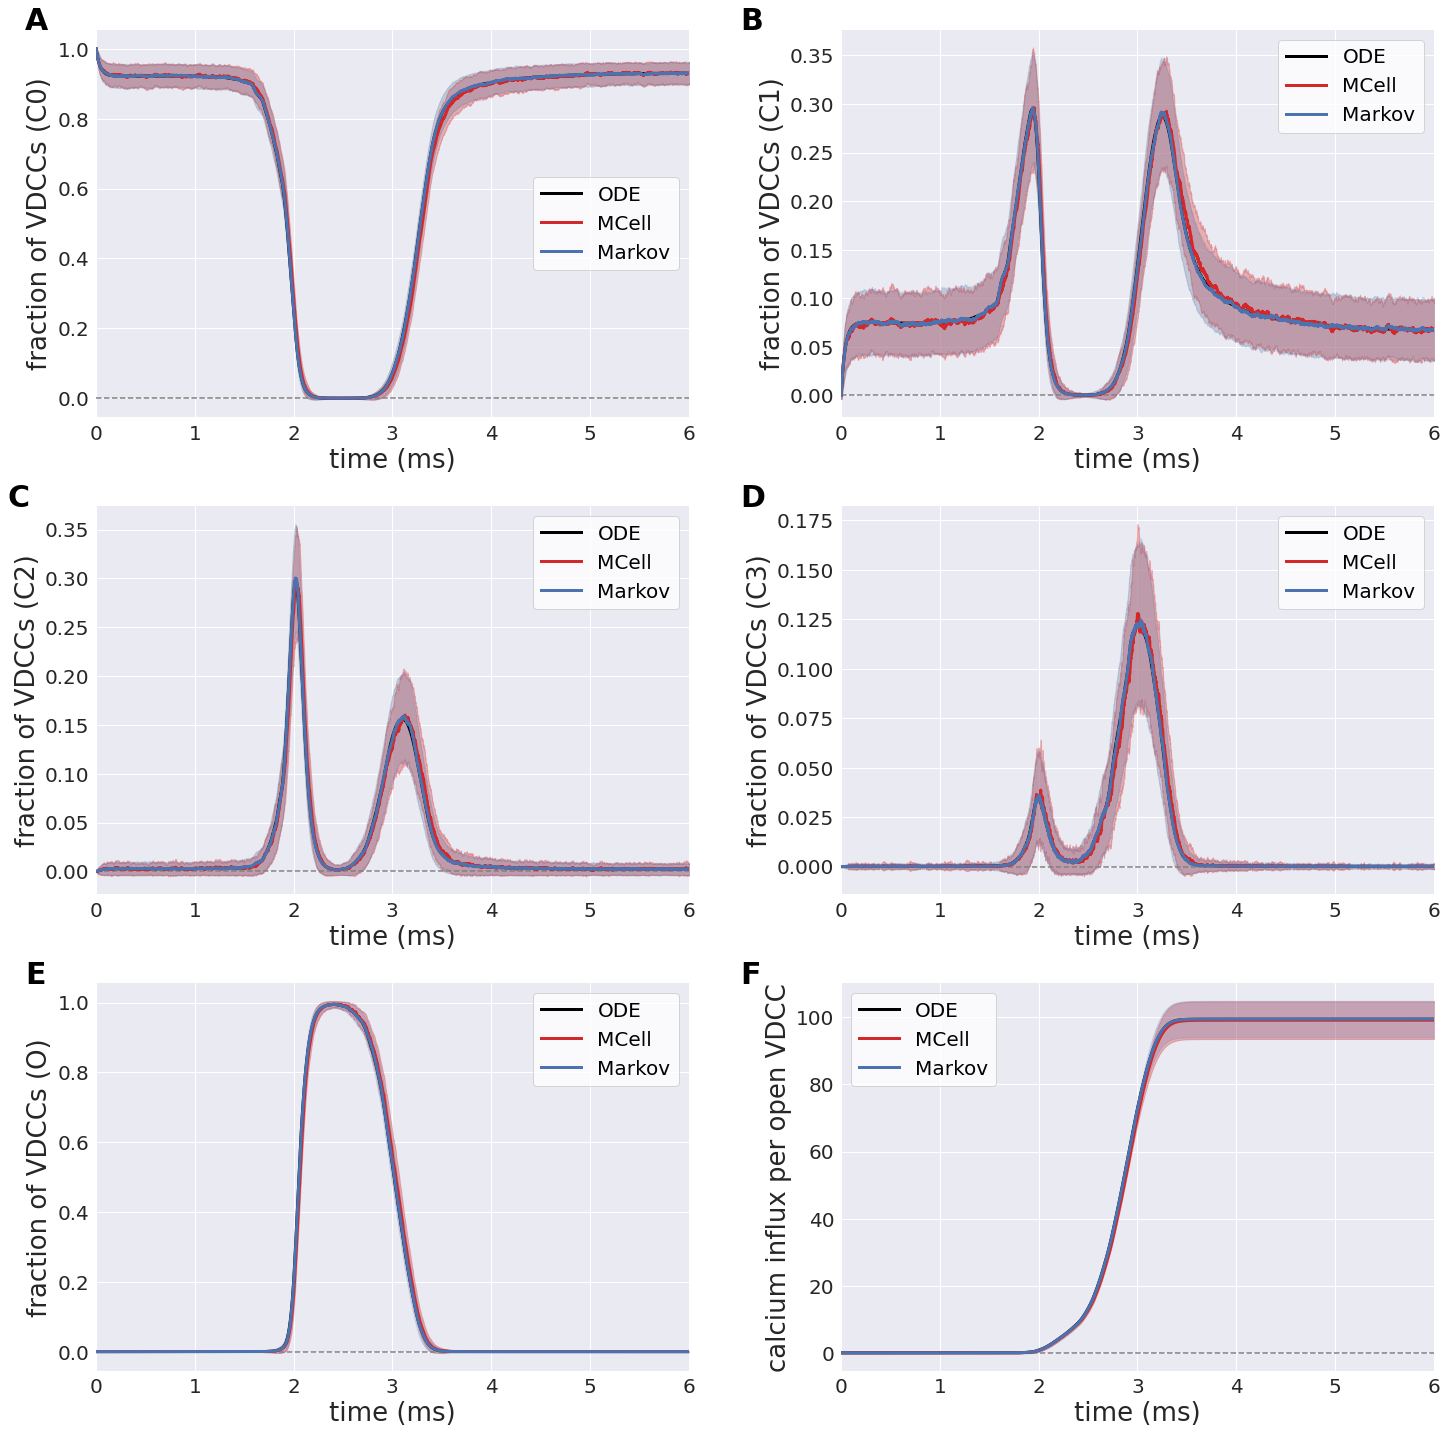

In [17]:
import string
def all_vdcc_plot(odesolve=False, mcell=False, markov=False, incl_std=False):
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
    
    names = markov_results.columns[9:].values
    
    t_offset = 1.5
    lwidth = 3
    
    for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
        if odesolve == True:
            a.plot(ode_results.t,ode_results.y[i], color='black', label="ODE", linewidth=lwidth)
            
        if i != 4:            
            ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
    
            # Cloud plot for sd
            a.fill_between(ode_results.t, np.add(ode_results.y[i,:], ode_sd), 
                   np.subtract(ode_results.y[i,:], ode_sd),alpha=0.5, color='lightgrey')

                    


    for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
        
        if i%2==0 and i != 2:
            a.text(-0.12, 1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
        elif i==2:
            a.text(-0.15, 1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
        else:
            a.text(-0.17, 1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
        
        a.axhline(xmax=2.5, color="grey", linestyle="--")
        #########
        # MCELL #
        #########
        if mcell == True:
            
            mcell_color = 'C3'
            mcell_mean = np.mean(mcell_results[i], axis=2)
            mcell_std = np.std(mcell_results[i], axis=2)
            
            # Plot mean
            a.plot(mcell_mean[:,0]*1000, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label='MCell')
 
            # Cloud plot for std dev
            if incl_std == True:
                a.fill_between(mcell_mean[:,0]*1000, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                               np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
                
    ##########
    # MARKOV #
    ##########
    if markov == True:
        if incl_std == False:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=lwidth, ax=a)
        else:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(markov_results["timepoints"], y=n, data=markov_results, 
                             ci="sd", linewidth=lwidth, ax=a, label="Markov")


    
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    states = ['C0', 'C1', 'C2', 'C3', 'O', '']
    for a, i in zip(ax.flatten(), range(len(states))):
        a.set_xlim(0, 6)
        a.tick_params(labelsize=20)
        a.set_xlabel('time (ms)', fontsize=26)
        a.legend(prop={"size":20})
        a.set_ylabel('fraction of VDCCs ({})'.format(states[i]), fontsize=26)
        
    ax[2,1].set_ylabel('calcium influx per open VDCC'.format(states[i]), fontsize=26)
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_all.png')
    plt.show()

all_vdcc_plot(odesolve=True, mcell=True, markov=True, incl_std=True)

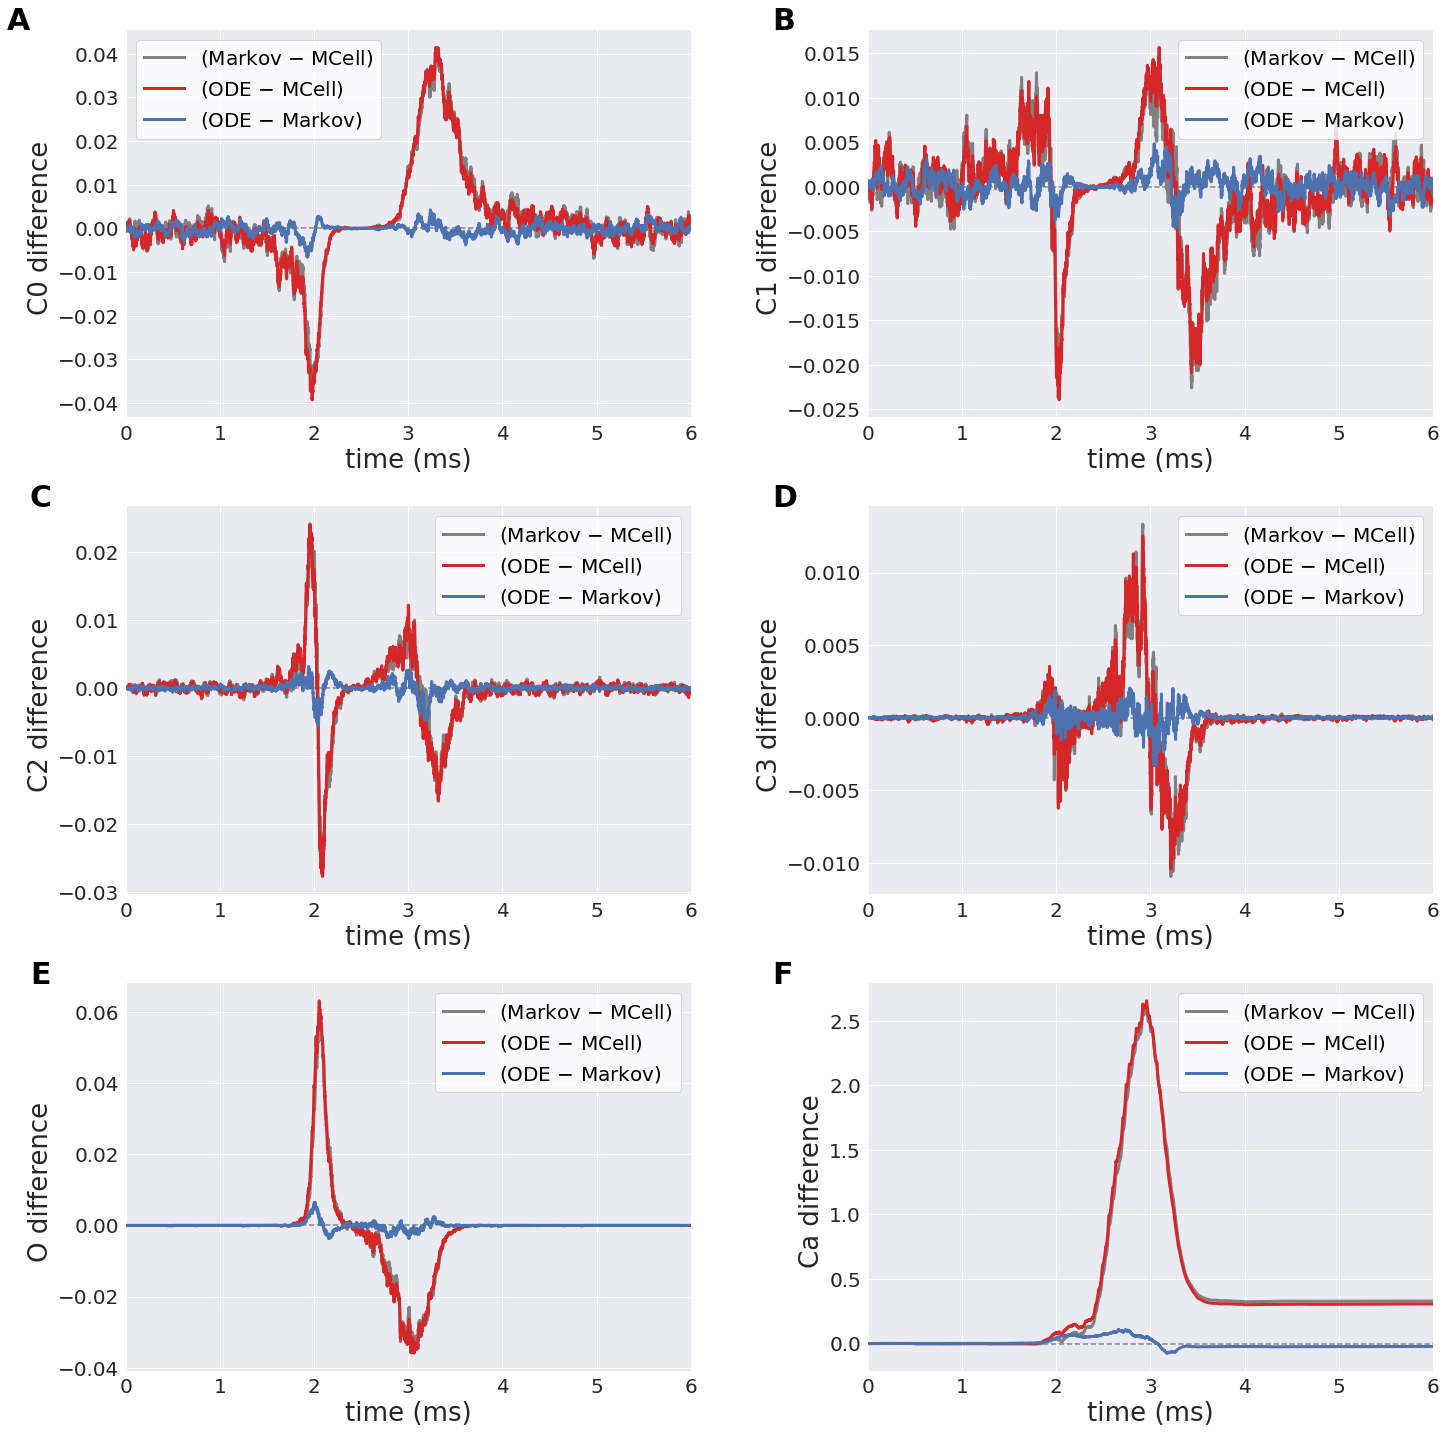

In [20]:
def vdcc_plot_diff(mcell_plot=False, markov_plot=False):
    '''
    Plot the difference between the ODe and stochastic dynamics curves
    
    '''
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
        
    names = markov_results.columns[9:].values 
    
    lwidth = 3
        
    #########
    # MCELL #
    #########
    i = 0
    for a, n in zip(ax.flatten(), names):
        a.axhline(xmax=6, color="grey", linestyle="--")
        
        # MCell mean
        mean = np.mean(mcell_results[i], axis=2)
        
        # subtract stochastic simulations
        a.plot(ode_results.t, np.asarray(avg_markov_results[n]) - mean[:,1], 
               color='grey', linewidth=lwidth, label = '(Markov $-$ MCell)')
        
        i += 1
            
        
    
    
    if mcell_plot == True:
        for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
            
            mcell_color = 'C3'
            
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            # MCell mean
            mean = np.mean(mcell_results[i], axis=2)
            

            
            # Subtract stochastic from ode
            a.plot(ode_results.t, ode_results.y[i] - mean[:,1], color=mcell_color, 
                   linewidth=lwidth, label='(ODE $-$ MCell)')
            
        
    ##########
    # MARKOV #
    ########## 
    if markov_plot == True:
        i = 0
        states = ['C0', 'C1', 'C2', 'C3', 'O', 'Ca']
        for a, n in zip(ax.flatten(), names):
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            a.plot(ode_results.t, ode_results.y[i] - np.asarray(avg_markov_results[n]), 
                   linewidth=lwidth, label = '(ODE $-$ Markov)')
            
            if i==0:
                a.text(-0.21, 1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
            else:
                a.text(-0.17, 1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
                
                   
            a.tick_params(labelsize=20)
            a.set_xlabel('time (ms)', fontsize=26)
            a.set_ylabel('{} difference '.format(states[i]), fontsize=26)
            a.legend(prop={"size":20})
            a.set_xlim(0, 6)
            
            i += 1
            
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_diff_all.png')
    plt.show()
    
vdcc_plot_diff(mcell_plot=True, markov_plot=True)

# Distributions

In [116]:
#sns.distplot()
#for a, i in zip(ax.flatten(), range(4,6)):
for i in range(6):
        #########
        # MCELL #
        #########
            
        mcell_color = 'C3'
        mcell_mean = np.mean(mcell_results[i], axis=2)
        mcell_std = np.std(mcell_results[i], axis=2)
        
mcell_mean.shape

(10001, 2)

Markov Open VDCCs (very different from ODE)

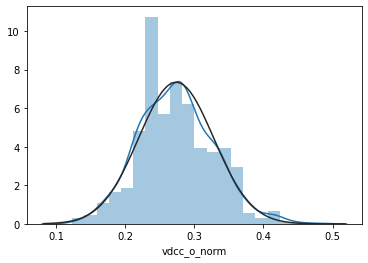

In [41]:
from scipy import stats
#sns.distplot(markov_results.loc[markov_results['timepoints'] == 3.137]['vdcc_o_norm'], fit=stats.norm, bins=30)
sns.distplot(markov_results.loc[markov_results['timepoints'] == 3.137]['vdcc_o_norm'], fit=stats.norm, bins=20)
plt.show()

Markov Open VDCCs (similar to ODE)

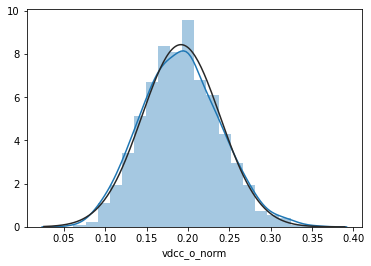

In [42]:
#sns.distplot(markov_results.loc[markov_results['timepoints'] == 2.0]['vdcc_o_norm'], fit=stats.norm, bins=30)
sns.distplot(markov_results.loc[markov_results['timepoints'] == 2.0]['vdcc_o_norm'], fit=stats.norm, bins=20)
plt.show()

MCell Open VDCCs (very different from ODE)

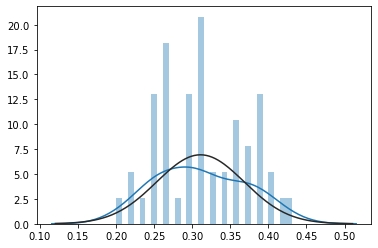

In [43]:
sns.distplot(mcell_results[4, int(3.137/(1e-3)), 1, :], fit=stats.norm, bins=30)
plt.show()

Markov Open VDCCs (similar to ODE)

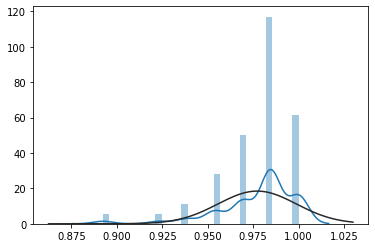

In [48]:
sns.distplot(mcell_results[4, int(2.6/(1e-3)), 1, :], fit=stats.norm, bins=30)
plt.show()

/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/margotwagner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NameError: name 'mean' is not defined

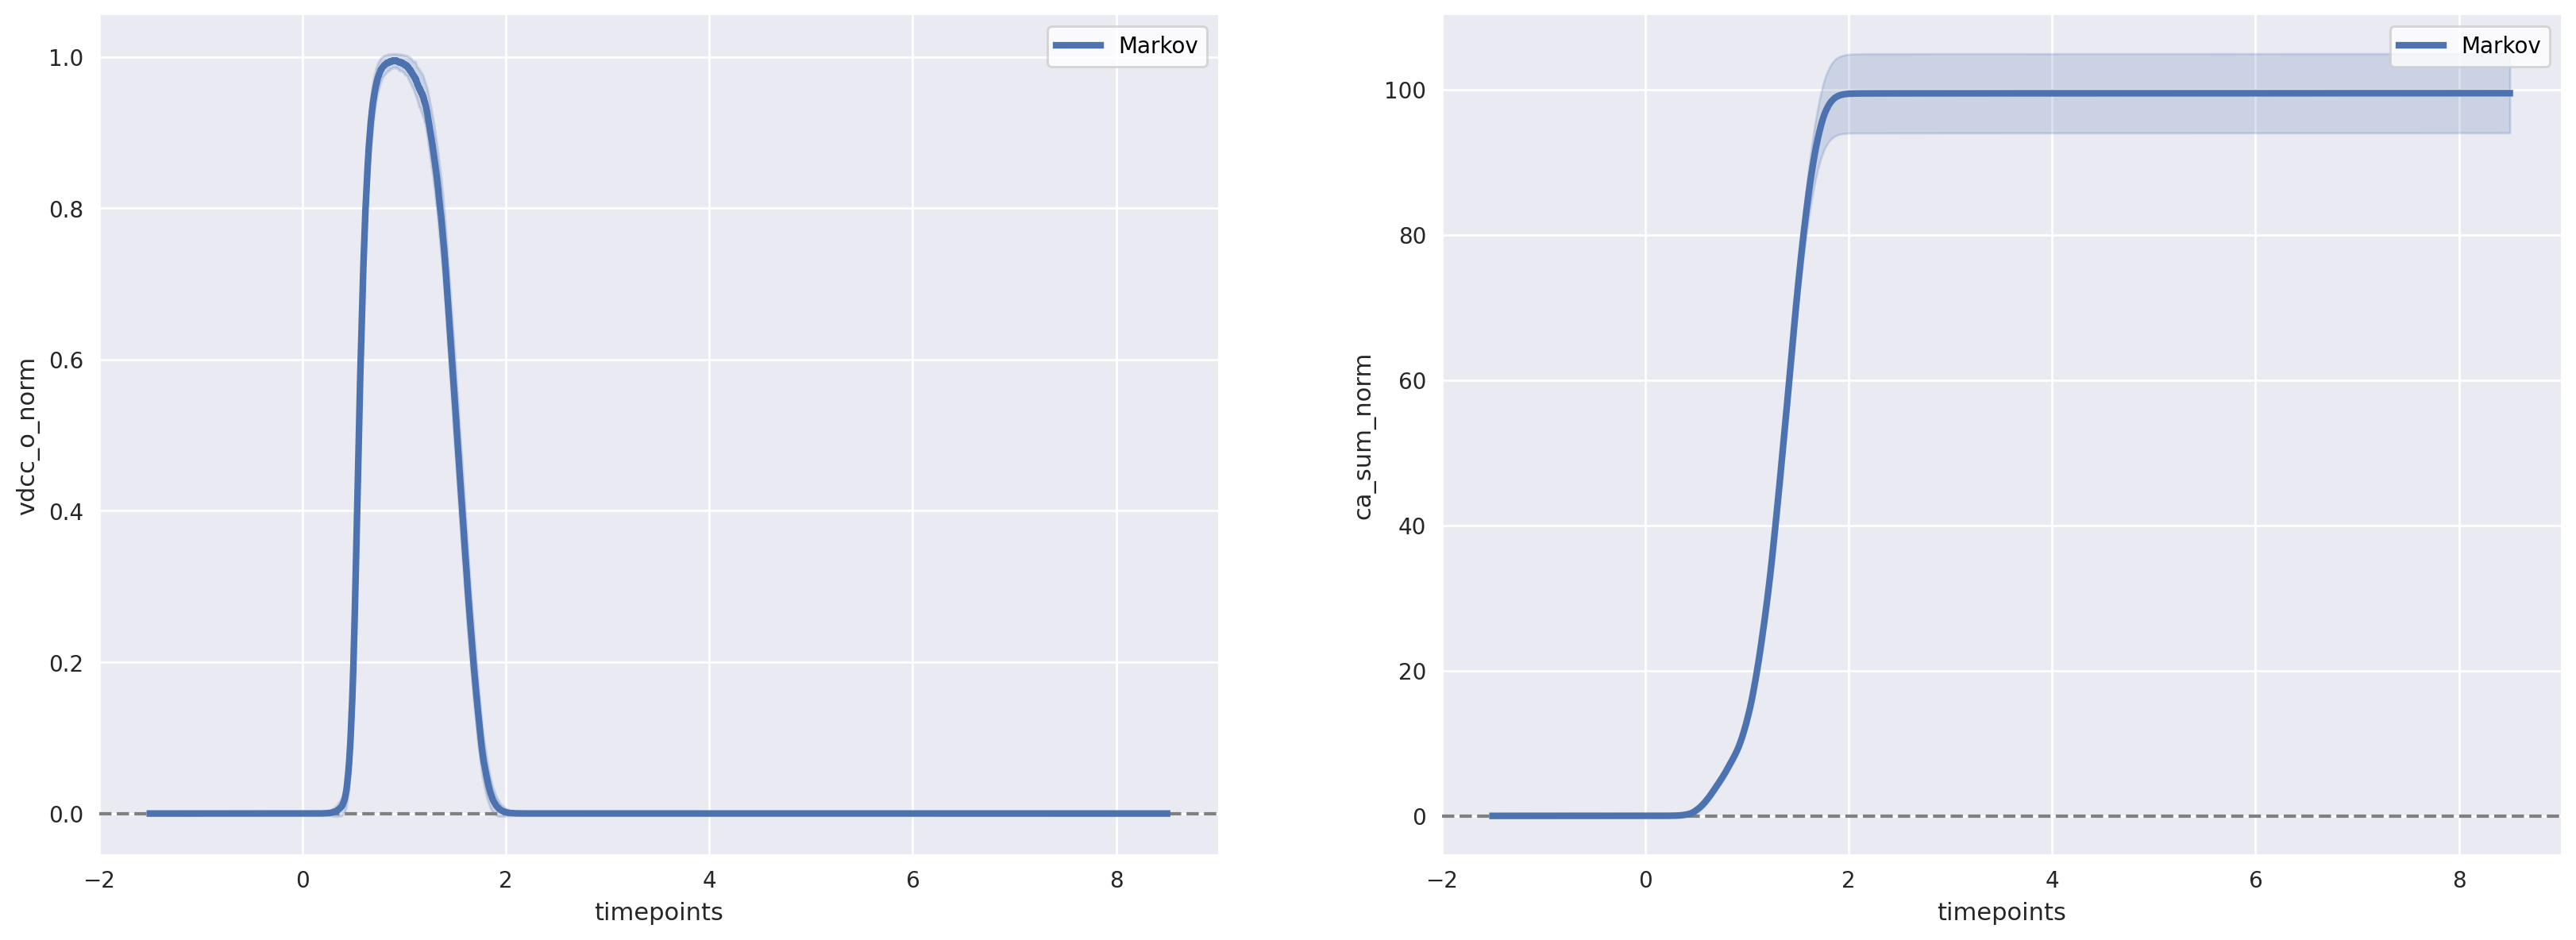

In [19]:
# Get average number of open VDCCs across the simulation
def vdcc_results2():
    '''
    Plot open vdcc's across all simulations and difference from ODE
    '''
    t_offset = 1.5
    lwidth = 3
    vdcc_i = 4
    ca_i = 5
    
    #fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    N_CHANS = 65

    name = 'vdcc_o_norm'
    ca_name = 'ca_sum_norm'
    
    ax[0].axhline(xmax=2.5, color="grey", linestyle="--")
    ax[1].axhline(xmax=2.5, color="grey", linestyle="--")

        
    ###########
    ## MARKOV #
    ###########
    # BLUE
    # Open VDCCs
    sns.lineplot(markov_results["timepoints"] - t_offset, y=name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[0], label="Markov")
    
    # Calcium
    sns.lineplot(markov_results["timepoints"] - t_offset, y=ca_name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[1], label="Markov")

    print(mean(markov_results[name]))
    
    

    
    #####################
    # PLOTTING SETTINGS #
    #####################
    ax[0].set_xlim(0, 2.5)
    ax[0].tick_params(labelsize=20)
    ax[0].set_ylabel('fraction of open VDCCs', fontsize=26)
    ax[0].set_xlabel('time (ms)', fontsize=26)
    ax[0].legend(prop={"size":20})
    
    ax[1].set_xlim(0, 2.5)
    ax[1].tick_params(labelsize=20)
    ax[1].set_ylabel('Ca influx per open VDCC', fontsize=26)
    ax[1].set_xlabel('time (ms)', fontsize=26)
    ax[1].legend(prop={"size":20})
    
    
    ax[0].text(-0.15, 1, "A", transform=ax[0].transAxes, size=30, weight='bold')
    ax[0].text(-0.25, 1, "B", transform=ax[1].transAxes, size=30, weight='bold')
    
    plt.tight_layout(pad=1, w_pad=6)
    #plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/both_vdcc_results.png')
    plt.show()
    
vdcc_results2()

In [22]:
markov_results.head()

,trial,timepoints,vdcc_c0,vdcc_c1,vdcc_c2,vdcc_c3,vdcc_o,ca_sum,ca,vdcc_c0_norm,vdcc_c1_norm,vdcc_c2_norm,vdcc_c3_norm,vdcc_o_norm,ca_sum_norm
0,1.0,0.000,65.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0
1,1.0,0.001,65.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0
2,1.0,0.002,65.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0
3,1.0,0.003,64.0,1.0,0.0,0.0,0.0,0.0,0.0,0.984615,0.015385,0.0,0.0,0.0,0.0
4,1.0,0.004,64.0,1.0,0.0,0.0,0.0,0.0,0.0,0.984615,0.015385,0.0,0.0,0.0,0.0


In [24]:
markov_results["vdcc_o"].mean()

6.166903809619038

In [25]:
10000*(markov_results["vdcc_o"].max() + markov_results["vdcc_o"].mean())

711669.0380961904